# Reto de Inteligencia Artificial
## **TELEFÓNICA** - MODELO HUBERT

**Grupo**:
* Leilani A.
* Lucia C.
* Natalia C.
* Maria Jose E.
* Maryam F.

## **PARTE 1**

**Importe de librerías neceserarios**

In [ ]:
# ================================
# Utilidades del sistema
# ================================
import os
import json
import random
import re
import csv
from collections import Counter, defaultdict

# ================================
# Manipulación de datos
# ================================
import numpy as np
import pandas as pd

# ================================
# Audio y Deep Learning
# ================================
import torch
import torchaudio
from transformers import HubertModel

# ================================
# Progreso de ejecución
# ================================
from tqdm import tqdm

# ================================
# Visualización
# ================================
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# Modelado y Métricas
# ================================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    learning_curve
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    RocCurveDisplay,
    make_scorer
)

# ================================
# Guardado y carga de modelos
# ================================
import joblib


Conectar con el drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Despues de limpiar los datos y balancear. Se decidió usar el total de audios : 5 160.


In [ ]:
# Ruta donde están todos los audios balanceados
balanced_audio_path = '/content/drive/MyDrive/TELEFONICA/balanced_audio'
balanced_audio_path

'/content/drive/MyDrive/TELEFONICA/balanced_audio'

## PARTE 2: EXTRACCIÓN DE EMBEDDINGS

In [ ]:
import os
import pandas as pd

balanced_audio_path = '/content/drive/MyDrive/TELEFONICA/balanced_audio'

# Recolectar rutas y etiquetas desde subcarpetas
data = []
for label in ['bonafide', 'spoof']:
    label_folder = os.path.join(balanced_audio_path, label)
    for fname in os.listdir(label_folder):
        if fname.endswith('.wav') or fname.endswith('.flac'):
            full_path = os.path.join(label_folder, fname)
            data.append({
                'Audio_file': fname,
                'Label': label,
                'filepath': full_path
            })

df_filtered = pd.DataFrame(data)

# Verificar
print(f"Total audios encontrados: {len(df_filtered)}")
print(df_filtered['Label'].value_counts())
df_filtered

In [ ]:
# ================================
# CARGAR PROTOCOLO ORIGINAL
# ================================

protocol_path = '/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
df_protocol = pd.read_csv(protocol_path, sep=' ', header=None, usecols=[1, 4], names=['Audio_file_no_ext', 'Protocol_Label'])

In [ ]:
# ================================
# PREPARAR df_filtered CON EXTENSIÓN REMOVIDA
# ================================
# Quitar extensión de los archivos en df_filtered
# Asegúrate de que df_filtered ya esté definido y contenga una columna 'Audio_file'
df_filtered['Audio_file_no_ext'] = df_filtered['Audio_file'].apply(lambda x: os.path.splitext(x)[0])

In [ ]:
# ================================
# UNIÓN CON EL PROTOCOLO
# ================================

df_final = pd.merge(df_filtered, df_protocol, on='Audio_file_no_ext', how='left')

# Verificación de audios sin etiqueta
missing = df_final['Protocol_Label'].isnull().sum()
print(f"🔍 Audios sin etiqueta de protocolo: {missing}")
if missing > 0:
    print(df_final[df_final['Protocol_Label'].isnull()].head())


🔍 Audios sin etiqueta de protocolo: 0


In [ ]:
# ================================
# CARGAR MODELO HuBERT
# ================================

# Usar GPU si está disponible, si no, usar CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Cargar el modelo HuBERT preentrenado
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()

# ================================
# FUNCIÓN PARA EXTRAER EMBEDDING DE UN AUDIO
# ================================

def extract_hubert_embedding(file_path):
    """
    Carga un archivo de audio, lo convierte a mono y 16kHz si es necesario,
    y devuelve el embedding promedio de la última capa oculta del modelo HuBERT.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"❌ Archivo no encontrado: {file_path}")

    waveform, sample_rate = torchaudio.load(file_path)

    if waveform.numel() == 0:
        raise ValueError(f"⚠️ Audio vacío: {file_path}")

    # Convertir a mono si es multicanal
    waveform = waveform.mean(dim=0) if waveform.ndim > 1 else waveform

    # Reescalar a 16 kHz si es necesario
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    # Formatear para el modelo
    input_tensor = waveform.unsqueeze(0).to(device)

    # Extraer embedding sin calcular gradientes
    with torch.no_grad():
        outputs = hubert_model(input_tensor)

    # Tomar el promedio del hidden state final como vector de embedding
    hidden_states = outputs.last_hidden_state.squeeze(0)
    embedding = hidden_states.mean(dim=0).cpu().numpy()

    return embedding

# ================================
# CREAR DATASET DE EMBEDDINGS
# ================================

X = []  # Lista de embeddings
y = []  # Lista de etiquetas

# Mapear etiquetas a números
label_map = {'bonafide': 0, 'spoof': 1}

# Iterar sobre el DataFrame que contiene rutas y etiquetas
for idx, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="Extrayendo embeddings"):
    try:
        emb = extract_hubert_embedding(row['filepath'])
        X.append(emb)
        y.append(label_map[row['Label']])
    except Exception as e:
        print(f"⚠️ Error procesando {row['filepath']}: {e}")

# Convertir a arrays de numpy
X = np.array(X)
y = np.array(y)

# ================================
# RESUMEN DE LA CANTIDAD POR CLASE
# ================================

unique, counts = np.unique(y, return_counts=True)
etiquetas = {0: 'bonafide', 1: 'spoof'}

print("📊 Distribución de clases:")
for label, count in zip(unique, counts):
    print(f"{etiquetas[label]}: {count}")

# ================================
# GUARDAR EMBEDDINGS
# ================================

save_dir = '/content/drive/MyDrive/TELEFONICA/hubert_features'
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, 'X_hubert.npy'), X)
np.save(os.path.join(save_dir, 'y_hubert.npy'), y)
print("✅ Embeddings y etiquetas guardados correctamente.")

# ================================
# CARGAR EMBEDDINGS PARA USO FUTURO
# ================================

X = np.load(os.path.join(save_dir, 'X_hubert.npy'))
y = np.load(os.path.join(save_dir, 'y_hubert.npy'))
print("📂 Embeddings cargados. Shape:", X.shape)


Extrayendo embeddings: 100%|██████████| 5160/5160 [2:10:05<00:00,  1.51s/it]


📊 Distribución de clases:
bonafide: 2580
spoof: 2580
✅ Embeddings y etiquetas guardados correctamente.
📂 Embeddings cargados. Shape: (5160, 768)


## PARTE 3: ENTRENAMIENTO DE MODELOS



### A. ENTRENAMIENTO DE MODELOS CON HIPERPARAMETROS ESTABLECIDO POR DEFECTO

MODELOS A EVALUAR:
- SVM Lineal
- SVM RBF
- Random Forest  
- XGBOOST

In [ ]:
# ================================
# CARGAR EMBEDDINGS GUARDADOS
# ================================
X = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/X_hubert.npy')
y = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/y_hubert.npy')

# 1. Dividir set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 2. Inicializar modelos
modelos = {
    "SVM Linear": SVC(kernel='linear', probability=True),
    "SVM RBF": SVC(kernel='rbf', C=10, gamma=0.01, probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
}

# ================================
# ENTRENAR Y EVALUAR
# ================================
resultados = []

for nombre, modelo in modelos.items():
    print(f"🚀 Entrenando modelo: {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    resultados.append({
        'Modelo': nombre,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-score': round(f1, 4)
    })

# ================================
# MOSTRAR RESULTADOS
# ================================
df_resultados = pd.DataFrame(resultados)
print("\n📊 Comparación de modelos:\n")
print(df_resultados.sort_values('F1-score', ascending=False).reset_index(drop=True))


save_path = '/content/drive/MyDrive/TELEFONICA/modelos_entrenados/'

os.makedirs(save_path, exist_ok=True)

for nombre, modelo in modelos.items():
    filename = os.path.join(save_path, f"modelo_{nombre.replace(' ', '_').lower()}.pkl")
    joblib.dump(modelo, filename)
    print(f"✅ Modelo guardado: {filename}")



🚀 Entrenando modelo: SVM Linear
🚀 Entrenando modelo: SVM RBF


KeyboardInterrupt: 

* **SVM arrasó**:
  Tiene **el mejor F1-score**, lo cual indica el mejor equilibrio entre precisión y recall. Además, su precisión (0.9941) y recall (0.9748) son muy altos. En otras palabras: casi no se le escapan los spoof, ni da falsos positivos.

* **XGBoost está muy cerca**:
  Tiene una precisión excelente (0.9919), pero cae un poco en recall. Aun así, es sólido y más flexible si quisieras tunearlo con `early stopping` o `feature importance`.

* **Random Forest pierde en recall**:
  Tiene **precisión altísima (0.9933)**, pero **bajo recall (0.8605)** → significa que **deja pasar muchos spoof como si fueran bonafide** (falsos negativos). Es decir: *si falla, es en lo más peligroso*.

### B. LEARNING CURVES


In [ ]:
# ================================
# CARGAR EMBEDDINGS GUARDADOS
# ================================
X = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/X_hubert.npy')
y = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/y_hubert.npy')


 Generar las curvas de aprendizaje ("lineales")
Estas curvas sirven para entender cómo aprende cada modelo con diferentes cantidades de datos.

📈 Generando learning curve para: SVM


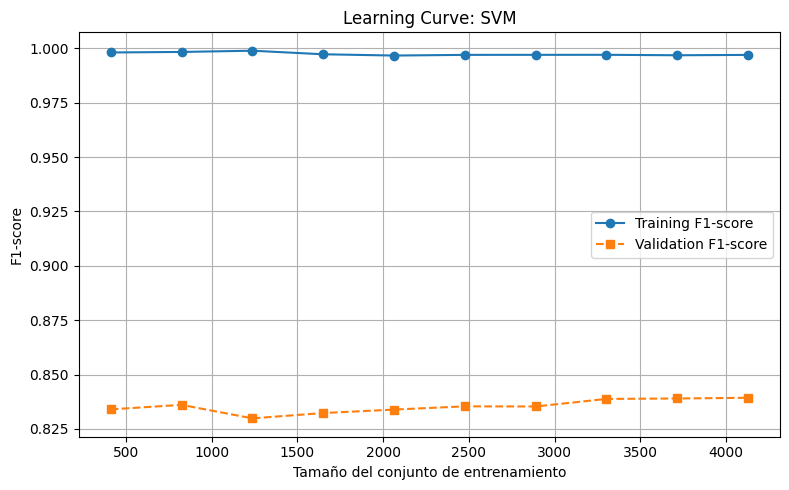

📈 Generando learning curve para: Random Forest


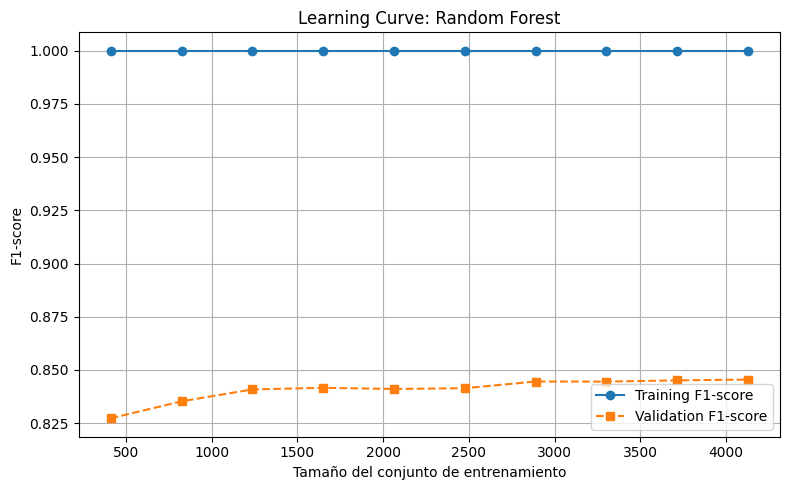

📈 Generando learning curve para: XGBoost


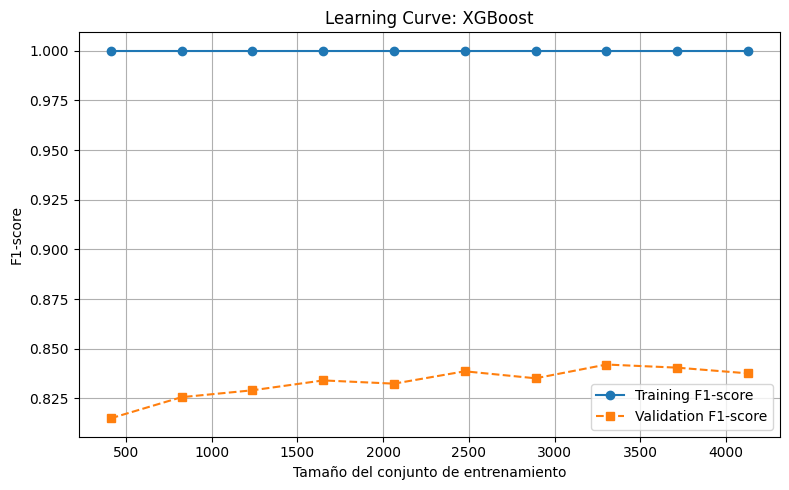

In [ ]:
# ================================
# 1. Cargar datos
# ================================
X = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/X_hubert.npy')
y = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/y_hubert.npy')

# ================================
# 2. Definir modelos
# ================================
modelos = {
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
}

# ================================
# 3. Función para graficar curva de aprendizaje
# ================================
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        cv=5,
        scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', label='Training F1-score')
    plt.plot(train_sizes, val_mean, 's--', label='Validation F1-score')
    plt.title(f"Learning Curve: {model_name}")
    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("F1-score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ================================
# 4. Generar curva para cada modelo
# ================================
for nombre, modelo in modelos.items():
    print(f"📈 Generando learning curve para: {nombre}")
    plot_learning_curve(modelo, X, y, nombre)


### C. CROSS VALIDATION

In [ ]:
from sklearn.model_selection import cross_val_score

# Comparar ambos modelos rápidamente
model_linear = SVC(kernel='linear', probability=True)
model_rbf = SVC(kernel='rbf', C=10, gamma=0.01, probability=True)

scores_linear = cross_val_score(model_linear, X, y, cv=5)
scores_rbf = cross_val_score(model_rbf, X, y, cv=5)

print("Linear SVM:", scores_linear.mean())
print("RBF SVM:", scores_rbf.mean())


Linear SVM: 0.8959302325581395
RBF SVM: 0.8968992248062015


In [ ]:
# Tu dataset
X = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/X_hubert.npy')
y = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/y_hubert.npy')

# Modelos a evaluar
modelos = {
    "SVM Linear": SVC(kernel='linear', probability=True),
    "SVM RBF": SVC(kernel='rbf', C=10, gamma=0.01, probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, use_label_encoder=False, eval_metric='logloss')
}

# Métricas
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score)
}

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = {}

for nombre, modelo in modelos.items():
    print(f"🔄 Validando {nombre}...")
    scores = cross_validate(modelo, X, y, cv=cv, scoring=scoring)
    resultados[nombre] = {
        "Accuracy": np.mean(scores['test_accuracy']),
        "Precision": np.mean(scores['test_precision']),
        "Recall": np.mean(scores['test_recall']),
        "F1-score": np.mean(scores['test_f1'])
    }

# Mostrar resultados
df_resultados = pd.DataFrame(resultados).T
df_resultados = df_resultados.sort_values(by="F1-score", ascending=False)
print(df_resultados)


🔄 Validando SVM Linear...
🔄 Validando SVM RBF...
🔄 Validando Random Forest...
🔄 Validando XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:39:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:40:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:41:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:42:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

               Accuracy  Precision    Recall  F1-score
SVM Linear     0.988953   0.991430  0.986434  0.988923
SVM RBF        0.988566   0.992197  0.984884  0.988519
XGBoost        0.972287   0.988777  0.955426  0.971796
Random Forest  0.934109   0.988691  0.878295  0.930137


In [ ]:
# === Métricas a usar ===
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === Resultados con medias y desviaciones ===
resumen = []

for nombre, modelo in modelos.items():
    scores = cross_validate(modelo, X, y, cv=cv, scoring=scoring, return_train_score=False)
    resumen.append({
        "Modelo": nombre,
        "Accuracy (mean)": np.mean(scores['test_accuracy']),
        "Accuracy (std)": np.std(scores['test_accuracy']),
        "Precision (mean)": np.mean(scores['test_precision']),
        "Precision (std)": np.std(scores['test_precision']),
        "Recall (mean)": np.mean(scores['test_recall']),
        "Recall (std)": np.std(scores['test_recall']),
        "F1-score (mean)": np.mean(scores['test_f1']),
        "F1-score (std)": np.std(scores['test_f1']),
    })

df_resultados = pd.DataFrame(resumen)
df_resultados = df_resultados.sort_values(by="F1-score (mean)", ascending=False)
print(df_resultados)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:41:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:42:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:44:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

          Modelo  Accuracy (mean)  Accuracy (std)  Precision (mean)  \
0     SVM Linear         0.988953        0.003101          0.991430   
1        SVM RBF         0.988566        0.003434          0.992197   
3        XGBoost         0.972287        0.006646          0.988777   
2  Random Forest         0.934109        0.008514          0.988691   

   Precision (std)  Recall (mean)  Recall (std)  F1-score (mean)  \
0         0.002638       0.986434      0.004246         0.988923   
1         0.003249       0.984884      0.005399         0.988519   
3         0.006023       0.955426      0.009573         0.971796   
2         0.005631       0.878295      0.016599         0.930137   

   F1-score (std)  
0        0.003117  
1        0.003462  
3        0.006829  
2        0.009549  


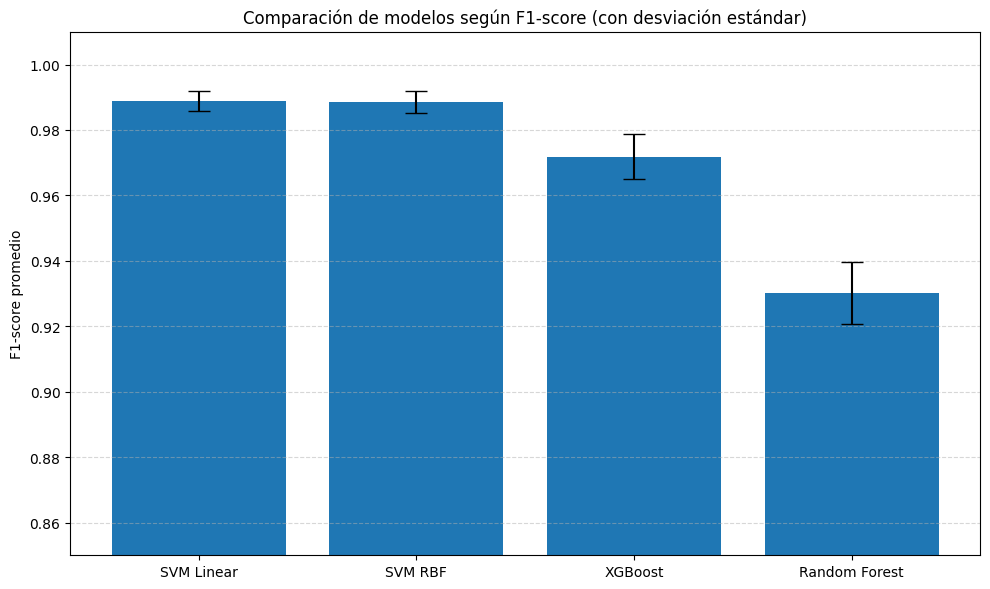

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer datos
modelos = df_resultados["Modelo"]
mean_f1 = df_resultados["F1-score (mean)"]
std_f1 = df_resultados["F1-score (std)"]

# Coordenadas X
x = np.arange(len(modelos))

# Crear gráfico
plt.figure(figsize=(10, 6))
plt.bar(x, mean_f1, yerr=std_f1, capsize=8)
plt.xticks(x, modelos)
plt.ylim(0.85, 1.01)
plt.ylabel("F1-score promedio")
plt.title("Comparación de modelos según F1-score (con desviación estándar)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## PARTE 4: EVALUACION DEL MODELO.

Evaluar con métricas y matriz de confusión

In [ ]:
modelo_final = "/content/drive/MyDrive/TELEFONICA/modelos_entrenados/modelo_svm.pkl"

In [ ]:
import joblib
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# === Cargar modelo entrenado
modelo = joblib.load("/content/drive/MyDrive/TELEFONICA/modelos_entrenados/modelo_svm.pkl")

# === X debe ser tu matriz de características, y y las etiquetas verdaderas
# Asegúrate de tener esto definido:
# X, y = ...

# === Predecir probabilidades
# Si tu SVM fue entrenado con probability=True:
y_scores = modelo.predict_proba(X)[:, 1]  # Probabilidad de clase positiva

# Si usaste decision_function en lugar de predict_proba:
# y_scores = modelo.decision_function(X)
# === Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# === Mostrar AUC
print(f"🔵 AUC: {roc_auc:.4f}")


🔵 AUC: 0.9998


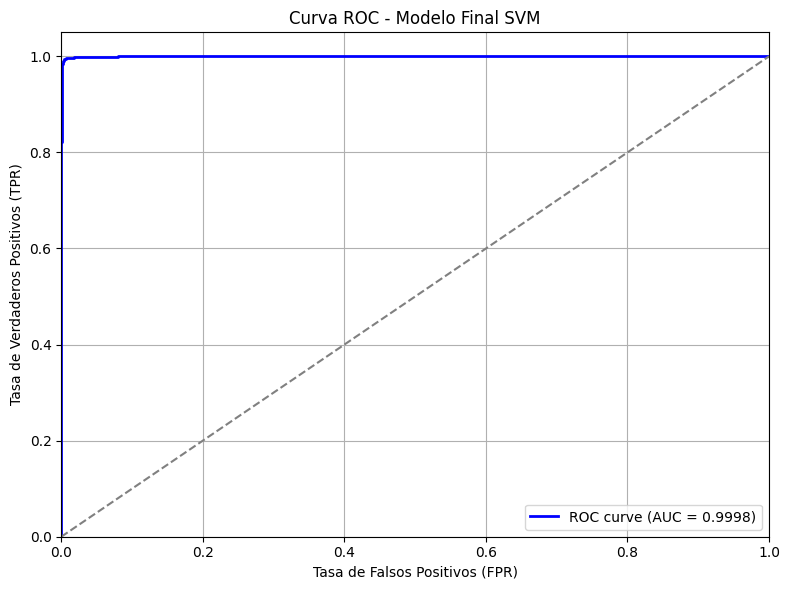

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # línea aleatoria
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo Final SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


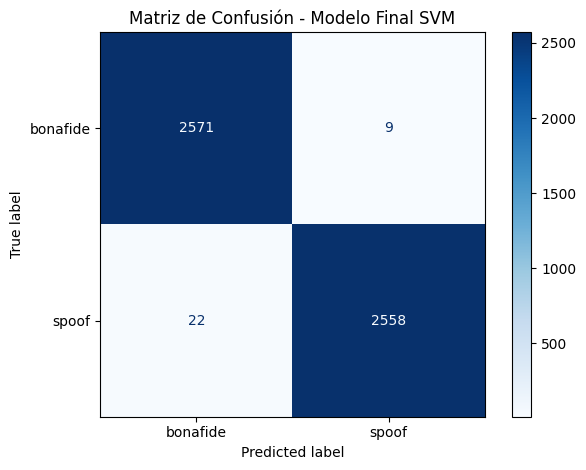

In [ ]:
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Cargar modelo
modelo = joblib.load("/content/drive/MyDrive/TELEFONICA/modelos_entrenados/modelo_svm.pkl")

# === Predecir clases
y_pred = modelo.predict(X)  # X es tu matriz de features


import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# === Calcular la matriz
cm = confusion_matrix(y, y_pred)

# === Mostrar la matriz con etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["bonafide", "spoof"])
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' para valores enteros
plt.title("Matriz de Confusión - Modelo Final SVM")
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred, target_names=["bonafide", "spoof"]))


              precision    recall  f1-score   support

    bonafide       0.99      1.00      0.99      2580
       spoof       1.00      0.99      0.99      2580

    accuracy                           0.99      5160
   macro avg       0.99      0.99      0.99      5160
weighted avg       0.99      0.99      0.99      5160



## PARTE 5: TESTEOS

### A. EVAL

## 1. TESTEO CON 1000 AUDIOS DE EVAL (AL AZAR SPOOF Y BONIFE)

SVM

In [ ]:
# ================================
# 1. CONFIGURACIÓN DE RUTAS
# ================================
carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"
modelo_path = "/content/drive/MyDrive/TELEFONICA/modelos_entrenados/modelo_svm.pkl"

# ================================
# 2. CARGAR MODELO SVM + HuBERT
# ================================
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()
model = joblib.load(modelo_path)

def extract_hubert_embedding(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")

    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.numel() == 0:
        raise ValueError(f"Audio vacío: {file_path}")

    waveform = waveform.mean(dim=0) if waveform.ndim > 1 else waveform

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    input_tensor = waveform.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = hubert_model(input_tensor)

    hidden_states = outputs.last_hidden_state.squeeze(0)
    embedding = hidden_states.mean(dim=0).cpu().numpy()
    return embedding

# ================================
# 3. CARGAR PROTOCOLO Y GÉNERO
# ================================
label_dict = {}
attack_type_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label
        attack_type_dict[file_id] = parts[3]

# Archivos de género
male_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.male.trl.txt"
female_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.female.trl.txt"

def load_gender_files(path):
    with open(path, "r") as f:
        return {line.strip().split()[1] + ".flac" for line in f}

male_files = load_gender_files(male_trl_path)
female_files = load_gender_files(female_trl_path)

# ================================
# 4. SELECCIONAR 1000 AUDIOS
# ================================
all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]
os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

# ================================
# 5. EVALUACIÓN
# ================================
correct, incorrect = 0, 0
y_true_eval, y_pred_eval = [], []
attack_errors, attack_total = [], []

male_true, male_pred = [], []
female_true = []
female_pred = []

print("🎧 Evaluando modelo SVM con HuBERT embeddings...\n")

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)

    try:
        emb = extract_hubert_embedding(full_path).reshape(1, -1)
    except Exception as e:
        print(f"⚠️ Error en {audio_file}: {e}")
        continue

    true_label = label_dict[audio_file]
    pred = model.predict(emb)[0]

    y_true_eval.append(true_label)
    y_pred_eval.append(pred)

    if audio_file in male_files:
        male_true.append(true_label)
        male_pred.append(pred)
    elif audio_file in female_files:
        female_true.append(true_label)
        female_pred.append(pred)

    if true_label == 1:
        attack = attack_type_dict[audio_file]
        attack_total.append(attack)
        if pred != true_label:
            attack_errors.append(attack)

    if pred == true_label:
        correct += 1
    else:
        incorrect += 1

# ================================
# 6. RESULTADOS GENERALES
# ================================
accuracy = correct / (correct + incorrect) * 100
print("\n=== RESULTADOS GENERALES ===")
print(f"✔️ Correctas:   {correct}")
print(f"❌ Incorrectas: {incorrect}")
print(f"🎯 Accuracy:    {accuracy:.2f}%\n")
print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
print("Matriz de confusión:")
print(confusion_matrix(y_true_eval, y_pred_eval))

# ================================
# 7. RESULTADOS POR GÉNERO
# ================================
print("\n=== VOCES MASCULINAS ===")
male_acc = sum(np.array(male_true) == np.array(male_pred)) / len(male_true) * 100 if male_true else 0
print(f"🎧 Total: {len(male_true)}  | Accuracy: {male_acc:.2f}%")
print(confusion_matrix(male_true, male_pred))

print("\n=== VOCES FEMENINAS ===")
female_acc = sum(np.array(female_true) == np.array(female_pred)) / len(female_true) * 100 if female_true else 0
print(f"🎧 Total: {len(female_true)}  | Accuracy: {female_acc:.2f}%")
print(confusion_matrix(female_true, female_pred))

# ================================
# 8. ERRORES POR TIPO DE ATAQUE
# ================================
print("\n=== ERRORES POR TIPO DE ATAQUE (SOLO SPOOF) ===")
total_attack_count = Counter(attack_total)
error_attack_count = Counter(attack_errors)

for attack in sorted(total_attack_count):
    total = total_attack_count[attack]
    errors = error_attack_count.get(attack, 0)
    rate = 100 * errors / total
    print(f"🔸 {attack}: {errors}/{total} mal clasificados ({rate:.1f}%)")


🎧 Evaluando modelo SVM con HuBERT embeddings...



100%|██████████| 1000/1000 [16:14<00:00,  1.03it/s]


=== RESULTADOS GENERALES ===
✔️ Correctas:   889
❌ Incorrectas: 111
🎯 Accuracy:    88.90%

              precision    recall  f1-score   support

    bonafide       0.49      0.92      0.64       108
       spoof       0.99      0.89      0.93       892

    accuracy                           0.89      1000
   macro avg       0.74      0.90      0.79      1000
weighted avg       0.94      0.89      0.90      1000

Matriz de confusión:
[[ 99   9]
 [102 790]]

=== VOCES MASCULINAS ===
🎧 Total: 274  | Accuracy: 86.50%
[[ 29   2]
 [ 35 208]]

=== VOCES FEMENINAS ===
🎧 Total: 726  | Accuracy: 89.81%
[[ 70   7]
 [ 67 582]]

=== ERRORES POR TIPO DE ATAQUE (SOLO SPOOF) ===
🔸 A07: 6/63 mal clasificados (9.5%)
🔸 A08: 3/79 mal clasificados (3.8%)
🔸 A09: 0/56 mal clasificados (0.0%)
🔸 A10: 27/71 mal clasificados (38.0%)
🔸 A11: 6/73 mal clasificados (8.2%)
🔸 A12: 0/63 mal clasificados (0.0%)
🔸 A13: 0/67 mal clasificados (0.0%)
🔸 A14: 3/66 mal clasificados (4.5%)
🔸 A15: 4/65 mal clasificados (6.2%)

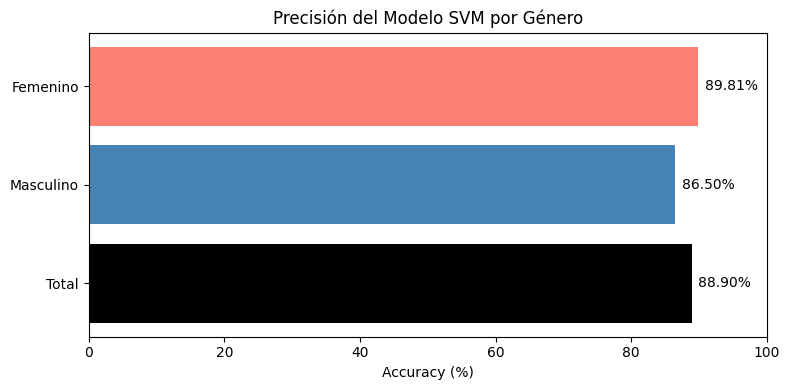

In [ ]:
# Datos de accuracy
categorias = ['Total', 'Masculino', 'Femenino']
accuracies = [88.90, 86.50, 89.81]

# Crear gráfico
plt.figure(figsize=(8, 4))
bars = plt.barh(categorias, accuracies, color=['black', 'steelblue', 'salmon'])
plt.xlabel("Accuracy (%)")
plt.title("Precisión del Modelo SVM por Género")
plt.xlim(0, 100)

# Añadir etiquetas a cada barra
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f"{width:.2f}%", va='center')

plt.tight_layout()
plt.show()

In [ ]:
# Calcular porcentaje de error por ataque
ataques = []
porcentaje_error = []
total = []

for attack in sorted(total_attack_count):  # sorted por nombre (A07, A08...)
    total_count = total_attack_count[attack]
    error_count = error_attack_count.get(attack, 0)
    error_pct = 100 * error_count / total_count

    ataques.append(attack)
    porcentaje_error.append(error_pct)
    total.append(total_count)

# Ordenar por % de error descendente
ataques_sorted_A = [x for _, x in sorted(zip(porcentaje_error, ataques), reverse=True)]
porcentaje_sorted_A = sorted(porcentaje_error, reverse=True)
total_sorted_A = [total_attack_count[a] for a in ataques_sorted_A]


In [ ]:
# Orden alfabético por nombre (A07, A08, ..., A19)
ataques_sorted_B = sorted(ataques)
porcentaje_sorted_B = [100 * error_attack_count.get(a, 0) / total_attack_count[a] for a in ataques_sorted_B]
total_sorted_B = [total_attack_count[a] for a in ataques_sorted_B]


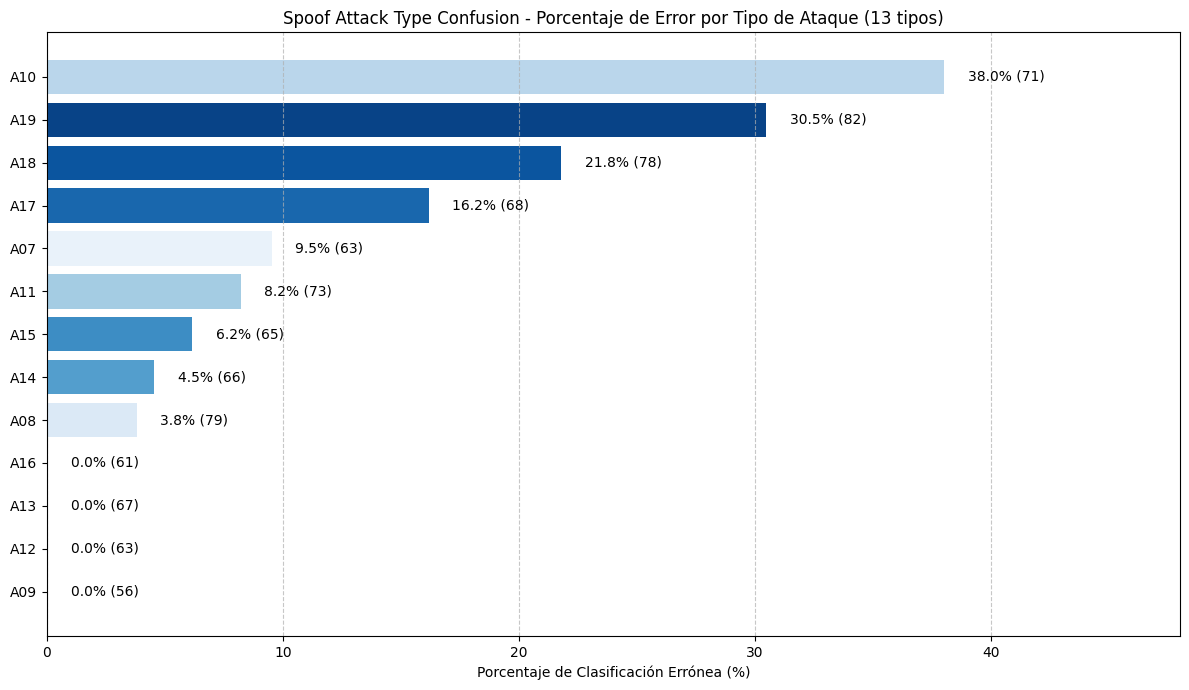

In [ ]:
# Calcular conteos de ataques totales y errores
attack_total_counts = Counter(attack_total)
attack_error_counts = Counter(attack_errors)

# Obtener ataques en orden alfabético (A07, A08, ..., A19)
ataques = sorted(attack_total_counts.keys())
total = [attack_total_counts[a] for a in ataques]
errors = [attack_error_counts.get(a, 0) for a in ataques]

# Calcular porcentaje de error por ataque
porcentaje_error = [100 * e / t if t > 0 else 0 for e, t in zip(errors, total)]

# OPCIÓN A: ordenar ataques por porcentaje de error ascendente
sorted_indices = np.argsort(porcentaje_error)
ataques_sorted = np.array(ataques)[sorted_indices]
porcentaje_sorted = np.array(porcentaje_error)[sorted_indices]
total_sorted = np.array(total)[sorted_indices]

# Paleta de colores (Blues)
colors = sns.color_palette("Blues", len(ataques))

# Gráfico
plt.figure(figsize=(12, 7))
bars = plt.barh(ataques_sorted, porcentaje_sorted, color=[colors[i] for i in sorted_indices])

# Etiquetas a la derecha de las barras
for bar, pct, total_val in zip(bars, porcentaje_sorted, total_sorted):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{pct:.1f}% ({total_val})', va='center', fontsize=10)

plt.xlabel('Porcentaje de Clasificación Errónea (%)')
plt.title(f'Spoof Attack Type Confusion - Porcentaje de Error por Tipo de Ataque ({len(ataques)} tipos)')
plt.xlim(0, max(porcentaje_sorted) + 10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<ipython-input-42-8adb15e3d126>:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-42-8adb15e3d126>:42: UserWarning: Glyph 129383 (\N{PIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129383 (\N{PIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


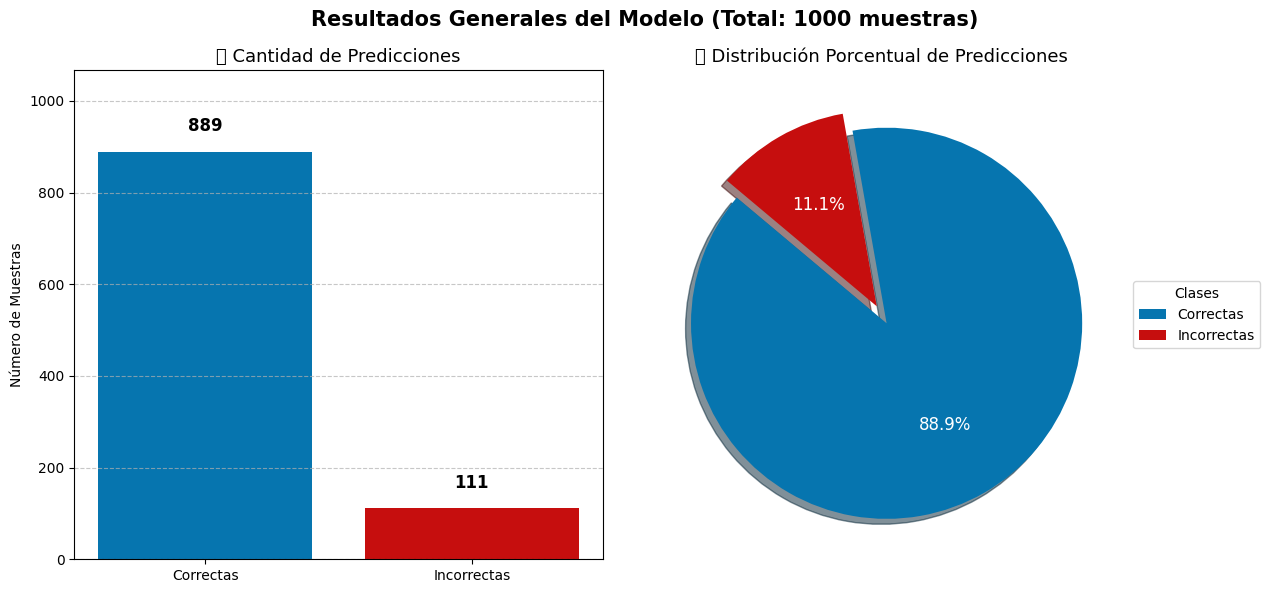

In [ ]:
# Datos
labels = ['Correctas', 'Incorrectas']
values = [correct, incorrect]
colors = ['#0675af', '#c60e0e']
explode = (0.05, 0.05)  # Explosión del pastel

# Crear figura y ejes
fig, axs = plt.subplots(1, 2, figsize=(13, 6))

# === Gráfico de barras ===
axs[0].bar(labels, values, color=colors)
axs[0].set_title('📊 Cantidad de Predicciones', fontsize=13)
axs[0].set_ylabel('Número de Muestras')
axs[0].set_ylim(0, max(values) * 1.2)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Etiquetas en las barras
for i, v in enumerate(values):
    axs[0].text(i, v + (max(values) * 0.05), str(v), ha='center', fontsize=12, fontweight='bold')

# === Gráfico de pastel ===
wedges, texts, autotexts = axs[1].pie(
    values,
    labels=labels,
    autopct='%1.1f%%',
    explode=explode,
    shadow=True,
    startangle=140,
    colors=colors,
    textprops={'color': 'white', 'fontsize': 12}
)

axs[1].set_title('🥧 Distribución Porcentual de Predicciones', fontsize=13)
axs[1].legend(wedges, labels, title="Clases", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# === Título general ===
total = correct + incorrect
plt.suptitle(f'Resultados Generales del Modelo (Total: {total} muestras)', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()


### B. AUDIOS LATAM

## PRUEBA CON AUDIOS DE LATAM -SVM


#### A. AUDIOS FALSOS - LATAM

In [ ]:
# ================================
# CONFIGURACIÓN
# ================================
carpeta_audios = '/content/drive/MyDrive/TELEFONICA/AUDIOS PRUEBA LATAM - SPOOFS'
modelo_path = '/content/drive/MyDrive/TELEFONICA/modelos_entrenados/modelo_svm.pkl'
csv_salida = '/content/drive/MyDrive/TELEFONICA/resultados_eval_spoof_only.csv'

# ================================
# CARGAR MODELO Y HuBERT
# ================================
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()
modelo = joblib.load(modelo_path)

# ================================
# FUNCIÓN: Extraer embedding
# ================================
def extract_hubert_embedding(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")

    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.numel() == 0:
        raise ValueError(f"Audio vacío: {file_path}")

    waveform = waveform.mean(dim=0) if waveform.ndim > 1 else waveform
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    input_tensor = waveform.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = hubert_model(input_tensor)

    hidden_states = outputs.last_hidden_state.squeeze(0)
    return hidden_states.mean(dim=0).cpu().numpy()

# ================================
# MAPAS Y LISTAS
# ================================
attack_types = ["StarGAN", "CycleGAN", "Diff", "Diffusion", "TTS", "TTS-StarGAN", "TTS-Diff"]

accent_map = {
    "vem": "Venezuela", "vef": "Venezuela",
    "pem": "Peru", "pef": "Peru",
    "com": "Colombia", "cof": "Colombia",
    "clm": "Chile", "clf": "Chile",
    "arm": "Argentina", "arf": "Argentina",
}

# ================================
# FUNCIONES AUXILIARES
# ================================
def extract_attack_type(filename):
    normalized = filename.replace("_", "-").lower()
    for attack in attack_types:
        if attack.lower().replace("_", "-") in normalized:
            return attack
    return "Unknown"

def extract_accent(filename):
    fname_lower = filename.lower()
    for key, country in accent_map.items():
        if f"_{key}_" in fname_lower or fname_lower.startswith(f"{key}_") or f"-{key}-" in fname_lower:
            return country
    return "Unknown"

def extract_gender(filename):
    fname_lower = filename.lower()
    if re.search(r"_(arf|vef|pef|cof|clf)_", fname_lower):
        return "Female"
    elif re.search(r"_(arm|vem|pem|com|clm)_", fname_lower):
        return "Male"
    else:
        return "Unknown"

def print_stats(stats_dict, title="Stats"):
    print(f"\n=== {title} ===")
    print(f"{'Grupo':<20} | {'Total':>5} | {'Tricked':>7} | {'Error Rate %':>11}")
    print("-" * 50)
    for group, stats in sorted(stats_dict.items()):
        total = stats['total']
        tricked = stats['tricked']
        error_rate = (tricked / total) * 100 if total > 0 else 0
        print(f"{group:<20} | {total:5d} | {tricked:7d} | {error_rate:11.2f}")

def export_summary_csv(filename, header, stats_dict):
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for group, stats in stats_dict.items():
            total = stats['total']
            tricked = stats['tricked']
            error_rate = (tricked / total) * 100 if total > 0 else 0
            writer.writerow([group, total, tricked, error_rate])

def print_unknown(label, unknown_list):
    if unknown_list:
        print(f"\n[!] Archivos con {label} desconocido ({len(unknown_list)}):")
        for fname in unknown_list:
            print(" -", fname)

# ================================
# EVALUACIÓN
# ================================
attack_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
accent_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
gender_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})

misclassified_samples = []
unknown_attacks = []
unknown_accents = []
unknown_genders = []

audio_files = [f for f in os.listdir(carpeta_audios) if f.endswith(".wav")]
print(f"Found {len(audio_files)} spoof audio files. Running predictions...")

for audio_file in tqdm(audio_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    try:
        features = extract_hubert_embedding(full_path).reshape(1, -1)
        pred = modelo.predict(features)[0]

        attack = extract_attack_type(audio_file)
        if attack == "Unknown":
            unknown_attacks.append(audio_file)
            continue

        accent = extract_accent(audio_file)
        if accent == "Unknown":
            unknown_accents.append(audio_file)

        gender = extract_gender(audio_file)
        if gender == "Unknown":
            unknown_genders.append(audio_file)

        attack_stats[attack]['total'] += 1
        accent_stats[accent]['total'] += 1
        gender_stats[gender]['total'] += 1

        if pred == 0:  # 0 = clasificado como bonafide
            attack_stats[attack]['tricked'] += 1
            accent_stats[accent]['tricked'] += 1
            gender_stats[gender]['tricked'] += 1
            misclassified_samples.append([audio_file, attack, accent, gender])

    except Exception as e:
        print(f"Error procesando {audio_file}: {e}")

# ================================
# RESULTADOS
# ================================
print_stats(attack_stats, title="Errores por tipo de ataque")
print_stats(accent_stats, title="Errores por acento/país")
print_stats(gender_stats, title="Errores por género")

# Exportar resúmenes
export_summary_csv("spoof_attack_error_summary.csv", ["AttackType", "Total", "Tricked", "ErrorRate"], attack_stats)
export_summary_csv("spoof_accent_error_summary.csv", ["Accent", "Total", "Tricked", "ErrorRate"], accent_stats)
export_summary_csv("spoof_gender_error_summary.csv", ["Gender", "Total", "Tricked", "ErrorRate"], gender_stats)

# Exportar errores individuales
with open("spoof_misclassified_samples.csv", "w", newline="") as ef:
    writer = csv.writer(ef)
    writer.writerow(["Filename", "AttackType", "Accent", "Gender"])
    writer.writerows(misclassified_samples)

# Mostrar etiquetas desconocidas
print_unknown("tipo de ataque", unknown_attacks)
print_unknown("acento", unknown_accents)
print_unknown("género", unknown_genders)

print("\n✅ Evaluación completada y archivos exportados.")


Found 240 spoof audio files. Running predictions...


100%|██████████| 240/240 [08:13<00:00,  2.06s/it]


=== Errores por tipo de ataque ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
CycleGAN             |    87 |       1 |        1.15
Diff                 |    75 |      21 |       28.00
StarGAN              |    78 |      19 |       24.36

=== Errores por acento/país ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
Argentina            |    48 |       5 |       10.42
Chile                |    48 |      10 |       20.83
Colombia             |    48 |       4 |        8.33
Peru                 |    48 |      12 |       25.00
Venezuela            |    48 |      10 |       20.83

=== Errores por género ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
Female               |   120 |      18 |       15.00
Male                 |   120 |      23 |       19.17

✅ Evaluación completada y archivos exportados.


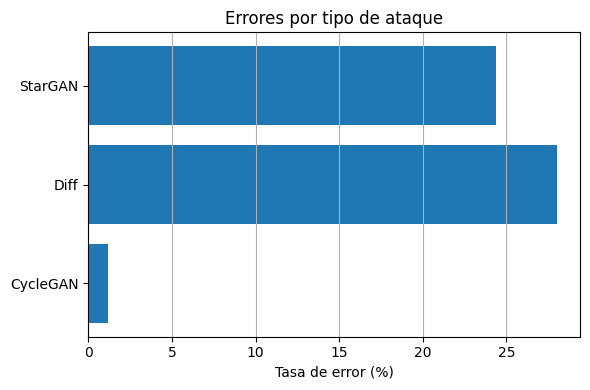

In [ ]:
ataques = ["CycleGAN", "Diff", "StarGAN"]
errores = [1.15, 28.00, 24.36]

plt.figure(figsize=(6,4))
plt.barh(ataques, errores)
plt.xlabel("Tasa de error (%)")
plt.title("Errores por tipo de ataque")
plt.grid(axis="x")
plt.tight_layout()
plt.show()


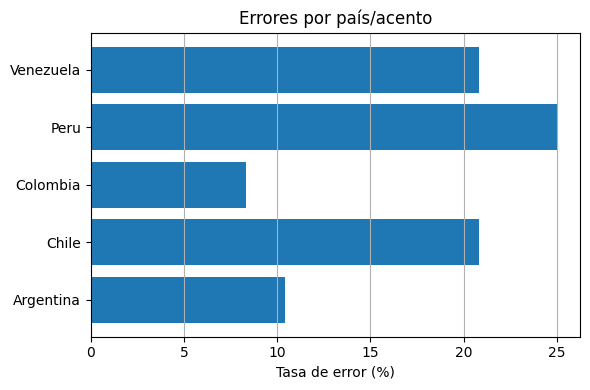

In [ ]:
paises = ["Argentina", "Chile", "Colombia", "Peru", "Venezuela"]
errores_pais = [10.42, 20.83, 8.33, 25.00, 20.83]

plt.figure(figsize=(6,4))
plt.barh(paises, errores_pais)
plt.xlabel("Tasa de error (%)")
plt.title("Errores por país/acento")
plt.grid(axis="x")
plt.tight_layout()
plt.show()


In [ ]:
def print_stats(stats_dict, title="Stats"):
    print(f"\n=== {title} ===")
    print(f"{'Grupo':<20} | {'Total':>5} | {'Tricked':>7} | {'Error Rate %':>11}")
    print("-" * 50)

    total_all = 0
    tricked_all = 0

    for group, stats in sorted(stats_dict.items()):
        try:
            total = stats['total']
            tricked = stats['tricked']
        except KeyError:
            print(f"[ERROR] Grupo sin clave esperada: {group}, contenido: {stats}")
            continue

        error_rate = (tricked / total) * 100 if total > 0 else 0
        total_all += total
        tricked_all += tricked
        print(f"{group:<20} | {total:5d} | {tricked:7d} | {error_rate:11.2f}")

    print("-" * 50)
    if total_all > 0:
        total_error_rate = (tricked_all / total_all) * 100
        print(f"{'TOTAL GENERAL':<20} | {total_all:5d} | {tricked_all:7d} | {total_error_rate:11.2f}")
    else:
        print("⚠️ No se encontraron datos válidos para calcular TOTAL GENERAL.")


In [ ]:
print(f"attack_stats: {dict(attack_stats)}")
print_stats(attack_stats, title="Errores por tipo de ataque")


attack_stats: {'CycleGAN': {'total': 87, 'tricked': 1}, 'Diff': {'total': 75, 'tricked': 21}, 'StarGAN': {'total': 78, 'tricked': 19}}

=== Errores por tipo de ataque ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
CycleGAN             |    87 |       1 |        1.15
Diff                 |    75 |      21 |       28.00
StarGAN              |    78 |      19 |       24.36
--------------------------------------------------
TOTAL GENERAL        |   240 |      41 |       17.08


#### B. AUDIOS VERDADES -LATAM

In [ ]:
# ================================
# CONFIGURACIÓN
# ================================
carpeta_audios = '/content/drive/MyDrive/TELEFONICA/AUDIOS PRUEBA LATAM - BONAFIDES'
modelo_path = '/content/drive/MyDrive/TELEFONICA/modelos_entrenados/modelo_svm.pkl'

# ================================
# CARGAR MODELO Y HuBERT
# ================================
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()
modelo = joblib.load(modelo_path)

# ================================
# FUNCIÓN: Extraer embedding
# ================================
def extract_hubert_embedding(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")

    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.numel() == 0:
        raise ValueError(f"Audio vacío: {file_path}")

    waveform = waveform.mean(dim=0) if waveform.ndim > 1 else waveform
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    input_tensor = waveform.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = hubert_model(input_tensor)

    hidden_states = outputs.last_hidden_state.squeeze(0)
    return hidden_states.mean(dim=0).cpu().numpy()

# ================================
# MAPEO DE ACENTO Y GÉNERO
# ================================
accent_map = {
    "vem": "Venezuela", "vef": "Venezuela",
    "pem": "Peru", "pef": "Peru",
    "com": "Colombia", "cof": "Colombia",
    "clm": "Chile", "clf": "Chile",
    "arm": "Argentina", "arf": "Argentina",
}

def extract_accent(filename):
    fname_lower = filename.lower()
    for key, country in accent_map.items():
        if f"_{key}_" in fname_lower or fname_lower.startswith(f"{key}_") or f"-{key}-" in fname_lower:
            return country
    return "Unknown"

def extract_gender(filename):
    fname_lower = filename.lower()
    if re.search(r"_(arf|vef|pef|cof|clf)_", fname_lower):
        return "Female"
    elif re.search(r"_(arm|vem|pem|com|clm)_", fname_lower):
        return "Male"
    else:
        return "Unknown"

# ================================
# EVALUACIÓN
# ================================
accent_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
gender_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
misclassified_samples = []
unknown_accents = []
unknown_genders = []

audio_files = [f for f in os.listdir(carpeta_audios) if f.endswith(".wav")]
print(f"Found {len(audio_files)} bonafides audio files. Running predictions...")

for audio_file in tqdm(audio_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    try:
        features = extract_hubert_embedding(full_path).reshape(1, -1)
        pred = modelo.predict(features)[0]

        accent = extract_accent(audio_file)
        if accent == "Unknown":
            unknown_accents.append(audio_file)

        gender = extract_gender(audio_file)
        if gender == "Unknown":
            unknown_genders.append(audio_file)

        accent_stats[accent]['total'] += 1
        gender_stats[gender]['total'] += 1

        if pred == 0:  # Clasificado incorrectamente como bonafide
            accent_stats[accent]['tricked'] += 1
            gender_stats[gender]['tricked'] += 1
            misclassified_samples.append([audio_file, accent, gender])

    except Exception as e:
        print(f"Error procesando {audio_file}: {e}")

# ================================
# RESULTADOS
# ================================
def print_stats(stats_dict, title):
    print(f"\n=== {title} ===")
    print(f"{'Grupo':<15} | {'Total':>5} | {'Tricked':>7} | {'Error Rate %':>11}")
    print("-" * 45)
    for group, stats in sorted(stats_dict.items()):
        total = stats['total']
        tricked = stats['tricked']
        error_rate = (tricked / total) * 100 if total > 0 else 0
        print(f"{group:<15} | {total:5d} | {tricked:7d} | {error_rate:11.2f}")

print_stats(accent_stats, "Errores por acento/país")
print_stats(gender_stats, "Errores por género")

# ================================
# EXPORTACIONES
# ================================
with open("bonafide_accent_error_summary.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Accent", "Total", "Tricked", "ErrorRate"])
    for group, stats in accent_stats.items():
        total = stats['total']
        tricked = stats['tricked']
        error_rate = (tricked / total) * 100 if total > 0 else 0
        writer.writerow([group, total, tricked, error_rate])

with open("bonafide_gender_error_summary.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Gender", "Total", "Tricked", "ErrorRate"])
    for group, stats in gender_stats.items():
        total = stats['total']
        tricked = stats['tricked']
        error_rate = (tricked / total) * 100 if total > 0 else 0
        writer.writerow([group, total, tricked, error_rate])

with open("bonafide_misclassified_samples.csv", "w", newline="") as ef:
    writer = csv.writer(ef)
    writer.writerow(["Filename", "Accent", "Gender"])
    writer.writerows(misclassified_samples)

def print_unknown(label, items):
    if items:
        print(f"\n[!] Archivos con {label} desconocido ({len(items)}):")
        for item in items:
            print(" -", item)

print_unknown("acento", unknown_accents)
print_unknown("género", unknown_genders)

print("\n✅ Evaluación completada. Resultados exportados.")


Found 132 bonafides audio files. Running predictions...


100%|██████████| 132/132 [04:15<00:00,  1.93s/it]


=== Errores por acento/país ===
Grupo           | Total | Tricked | Error Rate %
---------------------------------------------
Argentina       |    24 |      11 |       45.83
Chile           |    24 |      15 |       62.50
Colombia        |    28 |       3 |       10.71
Peru            |    36 |      14 |       38.89
Venezuela       |    20 |       3 |       15.00

=== Errores por género ===
Grupo           | Total | Tricked | Error Rate %
---------------------------------------------
Female          |    66 |      19 |       28.79
Male            |    66 |      27 |       40.91

✅ Evaluación completada. Resultados exportados.


<ipython-input-36-1234b43619f5>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x="País/Acento", y="Tasa de error (%)", palette="Reds_d")
<ipython-input-36-1234b43619f5>:30: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


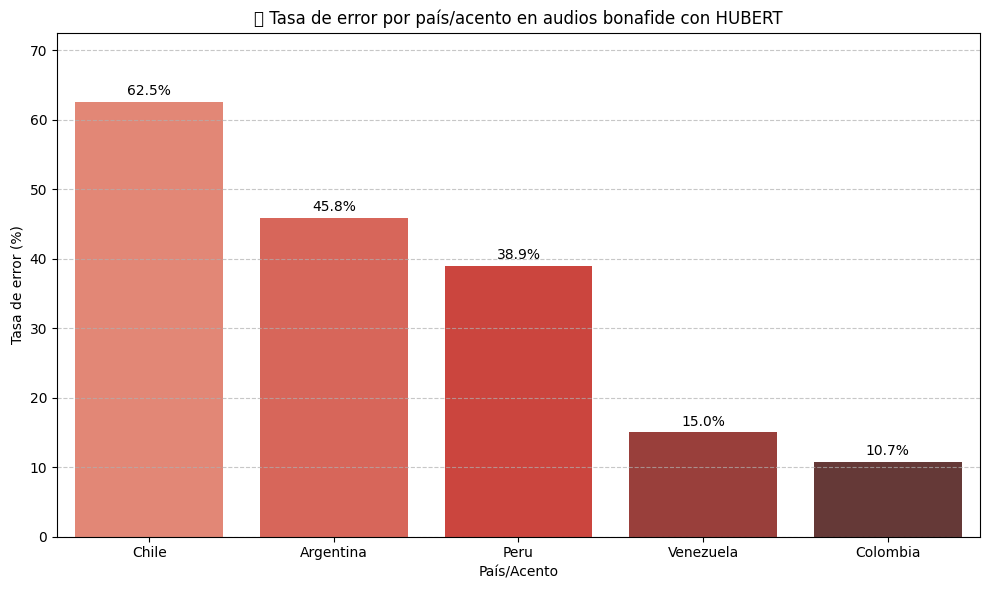

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el DataFrame con los datos ya ordenados
df = pd.DataFrame({
    "País/Acento": ["Chile", "Argentina", "Peru", "Venezuela", "Colombia"],
    "Audios evaluados": [24, 24, 36, 20, 28],
    "Errores": [15, 11, 14, 3, 3],
    "Tasa de error (%)": [62.50, 45.83, 38.89, 15.00, 10.71]
})

# Ordenar por tasa de error descendente
df_sorted = df.sort_values(by="Tasa de error (%)", ascending=False)

# Mostrar visualmente la tabla
df_sorted
# Crear gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted, x="País/Acento", y="Tasa de error (%)", palette="Reds_d")

# Añadir etiquetas
for index, row in df_sorted.iterrows():
    plt.text(x=index, y=row["Tasa de error (%)"] + 1, s=f"{row['Tasa de error (%)']:.1f}%", ha='center')

plt.title("🔍 Tasa de error por país/acento en audios bonafide con HUBERT")
plt.ylabel("Tasa de error (%)")
plt.ylim(0, df_sorted["Tasa de error (%)"].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## ENTRENAMIENTO DE MODELOS CON MEJORA DE HIPERPARAMETROS


1. Búsqueda de parámetros optimizados

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],  # Regularización
    'kernel': ['linear', 'rbf']  # Prueba también no lineal
}

grid_svm = GridSearchCV(SVC(), param_grid_svm, scoring='f1', cv=5)
grid_svm.fit(X, y)

print("Mejor SVM:", grid_svm.best_params_)


Mejor SVM: {'C': 0.1, 'kernel': 'rbf'}


In [ ]:
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],  # Regulariza divisiones
    'min_samples_leaf': [1, 2, 4]     # Regulariza hojas
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, scoring='f1', cv=5)
grid_rf.fit(X, y)

print("Mejor Random Forest:", grid_rf.best_params_)


Mejor Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist_xgb = {
    'n_estimators': [100],
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 4)
}

random_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
    param_distributions=param_dist_xgb,
    n_iter=50,  # Solo 50 combinaciones
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_xgb.fit(X, y)
print("Mejores parámetros XGBoost (Randomized):", random_xgb.best_params_)


Mejores parámetros XGBoost (Randomized): {'colsample_bytree': np.float64(0.9403713795070051), 'learning_rate': np.float64(0.29069049826628424), 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': np.float64(0.8985541885270792), 'reg_lambda': np.float64(3.4257162386383597), 'subsample': np.float64(0.6036788206466518)}


2. Entenamiento


In [ ]:
# ================================
# CARGAR EMBEDDINGS GUARDADOS
# ================================
X = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/X_hubert.npy')
y = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/y_hubert.npy')

In [ ]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# === Modelos optimizados ===
modelos = {
    'SVM': SVC(C=0.1, kernel='rbf', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10,
                                             min_samples_split=10, min_samples_leaf=4, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.2907, max_depth=6,
                             subsample=0.6037, colsample_bytree=0.9404,
                             reg_alpha=0.8986, reg_lambda=3.4257,
                             use_label_encoder=False, eval_metric='logloss', verbosity=0)
}

# === Entrenar y guardar ===
for nombre, modelo in modelos.items():
    print(f"🚀 Entrenando y guardando: {nombre}")
    modelo.fit(X_train, y_train)
    joblib.dump(modelo, f'modelo_{nombre.lower().replace(" ", "_")}_optimizado.pkl')

print("✅ Todos los modelos han sido guardados como archivos .pkl")


🚀 Entrenando y guardando: SVM
🚀 Entrenando y guardando: Random Forest
🚀 Entrenando y guardando: XGBoost
✅ Todos los modelos han sido guardados como archivos .pkl


🚀 Entrenando SVM


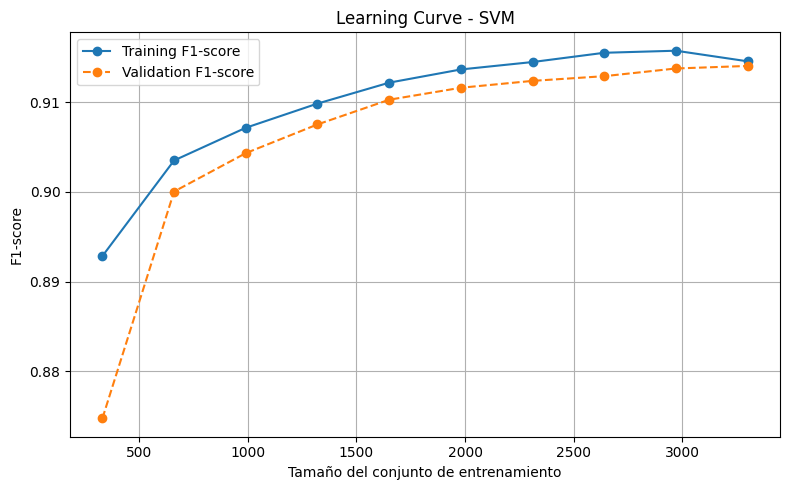

🚀 Entrenando Random Forest


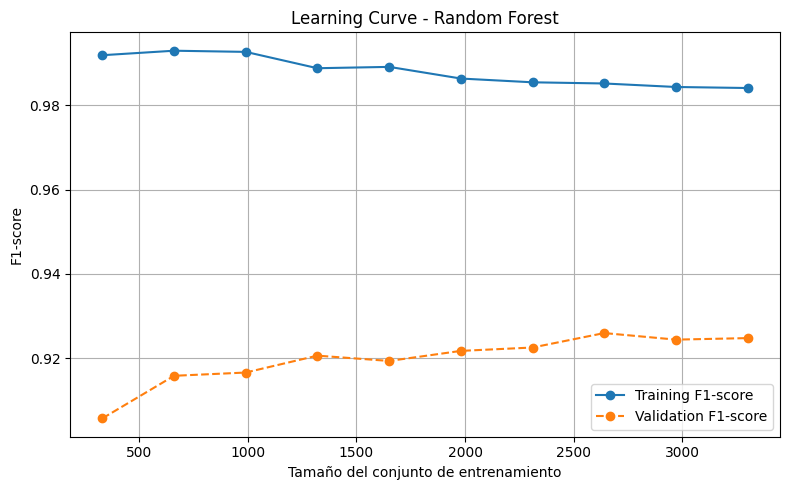

🚀 Entrenando XGBoost


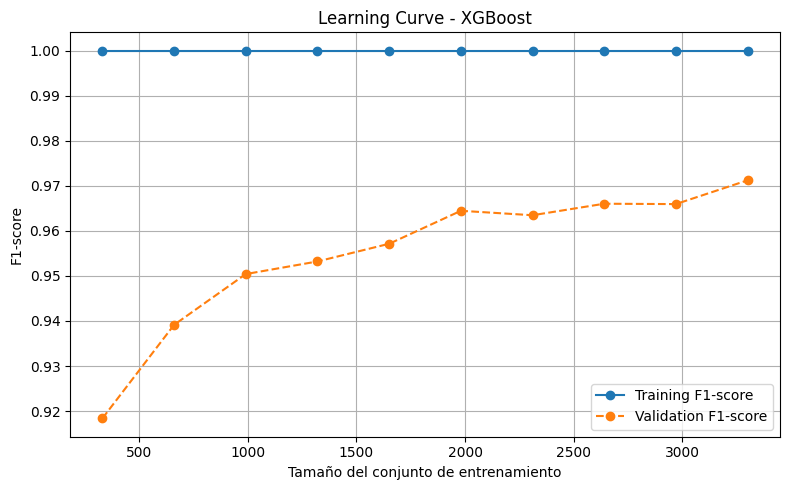


📊 Comparación final en test set:
          Modelo  Accuracy  Precision  Recall  F1-score
2        XGBoost    0.9690     0.9959  0.9419    0.9681
1  Random Forest    0.9167     0.9954  0.8372    0.9095
0            SVM    0.9070     0.9976  0.8159    0.8977


In [ ]:
# === Función para graficar curva ===
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='f1', n_jobs=-1, shuffle=True, random_state=42
    )
    train_scores_mean = train_scores.mean(axis=1)
    val_scores_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training F1-score')
    plt.plot(train_sizes, val_scores_mean, 'o--', label='Validation F1-score')
    plt.title(f'Learning Curve - {title}')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('F1-score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Evaluar y graficar ===
resultados = []
for nombre, modelo in modelos.items():
    print(f"🚀 Entrenando {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    resultados.append({
        'Modelo': nombre,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
        'F1-score': round(f1_score(y_test, y_pred), 4)
    })

    # Graficar curva
    plot_learning_curve(modelo, X_train, y_train, nombre)

# === Mostrar tabla de resultados ===
df_resultados = pd.DataFrame(resultados).sort_values('F1-score', ascending=False)
print("\n📊 Comparación final en test set:")
print(df_resultados)

## PRUEBAS

### PRUEBA CON AUDIOS EVAL

##### 1.  **modelo_xgboost_optimizado**

🎧 Evaluando modelo con HuBERT embeddings...



100%|██████████| 1000/1000 [15:09<00:00,  1.10it/s]



=== RESULTADOS GENERALES ===
✔️ Correctas:   874
❌ Incorrectas: 126
🎯 Accuracy:    87.40%
              precision    recall  f1-score   support

    bonafide       0.46      0.97      0.62       108
       spoof       1.00      0.86      0.92       892

    accuracy                           0.87      1000
   macro avg       0.73      0.92      0.77      1000
weighted avg       0.94      0.87      0.89      1000

Matriz de confusión:
[[105   3]
 [123 769]]

=== VOCES MASCULINAS ===
🎧 Total: 274  | Accuracy: 87.59%
[[ 31   0]
 [ 34 209]]

=== VOCES FEMENINAS ===
🎧 Total: 726  | Accuracy: 87.33%
[[ 74   3]
 [ 89 560]]

=== ERRORES POR TIPO DE ATAQUE (SOLO SPOOF) ===
🔸 A07: 0/63 mal clasificados (0.0%)
🔸 A08: 2/79 mal clasificados (2.5%)
🔸 A09: 0/56 mal clasificados (0.0%)
🔸 A10: 1/71 mal clasificados (1.4%)
🔸 A11: 0/73 mal clasificados (0.0%)
🔸 A12: 0/63 mal clasificados (0.0%)
🔸 A13: 0/67 mal clasificados (0.0%)
🔸 A14: 0/66 mal clasificados (0.0%)
🔸 A15: 1/65 mal clasificados (1.5%)
🔸 

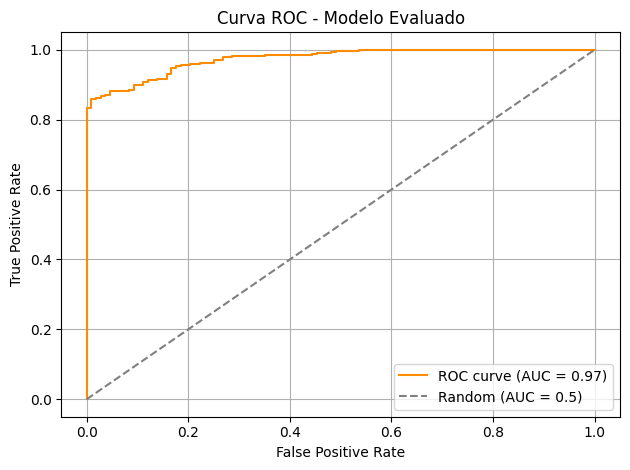

In [ ]:

# ================================
# 1. CONFIGURACIÓN DE RUTAS
# ================================
carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"
modelo_path = '/content/drive/MyDrive/TELEFONICA/modelos_entrenados_optimizados/modelo_xgboost_optimizado.pkl'
male_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.male.trl.txt"
female_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.female.trl.txt"

# ================================
# 2. CARGAR MODELO + HuBERT
# ================================
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()
model = joblib.load(modelo_path)

def extract_hubert_embedding(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.numel() == 0:
        raise ValueError(f"Audio vacío: {file_path}")
    waveform = waveform.mean(dim=0) if waveform.ndim > 1 else waveform
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    input_tensor = waveform.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = hubert_model(input_tensor)
    hidden_states = outputs.last_hidden_state.squeeze(0)
    embedding = hidden_states.mean(dim=0).cpu().numpy()
    return embedding

# ================================
# 3. CARGAR PROTOCOLO Y GÉNERO
# ================================
label_dict = {}
attack_type_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label
        attack_type_dict[file_id] = parts[3]

def load_gender_files(path):
    with open(path, "r") as f:
        return {line.strip().split()[1] + ".flac" for line in f}

male_files = load_gender_files(male_trl_path)
female_files = load_gender_files(female_trl_path)

# ================================
# 4. SELECCIONAR 1000 AUDIOS
# ================================
all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]
os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

# ================================
# 5. EVALUACIÓN
# ================================
correct, incorrect = 0, 0
y_true_eval, y_pred_eval = [], []
attack_errors, attack_total = [], []
embeddings = []

male_true, male_pred = [], []
female_true, female_pred = [], []

print("🎧 Evaluando modelo con HuBERT embeddings...\n")

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    try:
        emb = extract_hubert_embedding(full_path).reshape(1, -1)
        embeddings.append(emb[0])
    except Exception as e:
        print(f"⚠️ Error en {audio_file}: {e}")
        continue
    true_label = label_dict[audio_file]
    pred = model.predict(emb)[0]
    y_true_eval.append(true_label)
    y_pred_eval.append(pred)
    if audio_file in male_files:
        male_true.append(true_label)
        male_pred.append(pred)
    elif audio_file in female_files:
        female_true.append(true_label)
        female_pred.append(pred)
    if true_label == 1:
        attack = attack_type_dict[audio_file]
        attack_total.append(attack)
        if pred != true_label:
            attack_errors.append(attack)
    if pred == true_label:
        correct += 1
    else:
        incorrect += 1

# ================================
# 6. RESULTADOS GENERALES
# ================================
accuracy = correct / (correct + incorrect) * 100
print("\n=== RESULTADOS GENERALES ===")
print(f"✔️ Correctas:   {correct}")
print(f"❌ Incorrectas: {incorrect}")
print(f"🎯 Accuracy:    {accuracy:.2f}%")
print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
print("Matriz de confusión:")
print(confusion_matrix(y_true_eval, y_pred_eval))

# ================================
# 7. RESULTADOS POR GÉNERO
# ================================
print("\n=== VOCES MASCULINAS ===")
male_acc = sum(np.array(male_true) == np.array(male_pred)) / len(male_true) * 100 if male_true else 0
print(f"🎧 Total: {len(male_true)}  | Accuracy: {male_acc:.2f}%")
print(confusion_matrix(male_true, male_pred))

print("\n=== VOCES FEMENINAS ===")
female_acc = sum(np.array(female_true) == np.array(female_pred)) / len(female_true) * 100 if female_true else 0
print(f"🎧 Total: {len(female_true)}  | Accuracy: {female_acc:.2f}%")
print(confusion_matrix(female_true, female_pred))

# ================================
# 8. ERRORES POR TIPO DE ATAQUE
# ================================
print("\n=== ERRORES POR TIPO DE ATAQUE (SOLO SPOOF) ===")
total_attack_count = Counter(attack_total)
error_attack_count = Counter(attack_errors)
for attack in sorted(total_attack_count):
    total = total_attack_count[attack]
    errors = error_attack_count.get(attack, 0)
    rate = 100 * errors / total
    print(f"🔸 {attack}: {errors}/{total} mal clasificados ({rate:.1f}%)")

# ================================
# 9. CURVA ROC
# ================================
y_proba = model.predict_proba(np.vstack(embeddings))[:, 1]
fpr, tpr, _ = roc_curve(y_true_eval, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Modelo Evaluado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


📊 MÉTRICAS DEL MODELO XGBoost:
Accuracy   : 0.9690
Precision  : 0.9959
Recall     : 0.9419
F1-score   : 0.9681
AUC (ROC)  : 0.9972

📋 Clasificación por clase:
              precision    recall  f1-score   support

    Bonafide       0.94      1.00      0.97       516
       Spoof       1.00      0.94      0.97       516

    accuracy                           0.97      1032
   macro avg       0.97      0.97      0.97      1032
weighted avg       0.97      0.97      0.97      1032



<ipython-input-20-a309659f8c9c>:54: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


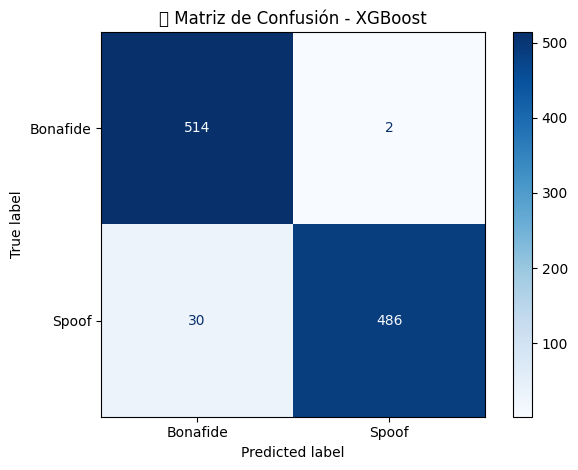

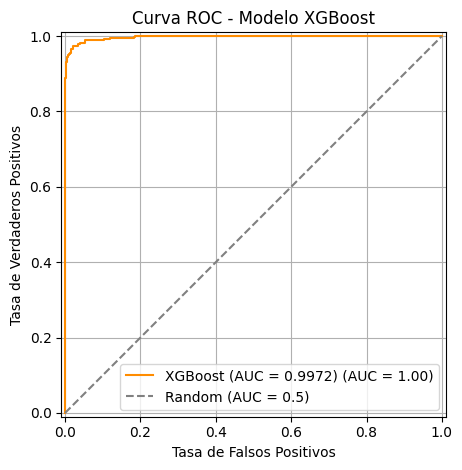

In [ ]:
# ================================
# 1. Cargar embeddings
# ================================
X = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/X_hubert.npy')
y = np.load('/content/drive/MyDrive/TELEFONICA/hubert_features/y_hubert.npy')

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ================================
# 2. Cargar modelo optimizado
# ================================
modelo_path = '/content/drive/MyDrive/TELEFONICA/modelos_entrenados_optimizados/modelo_xgboost_optimizado.pkl'
modelo = joblib.load(modelo_path)

# ================================
# 3. Predicción y probabilidades
# ================================
y_pred = modelo.predict(X_test)
y_proba = modelo.predict_proba(X_test)[:, 1]  # Probabilidad de clase "spoof"

# ================================
# 4. Métricas principales
# ================================
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# ================================
# 5. Imprimir métricas
# ================================
print("📊 MÉTRICAS DEL MODELO XGBoost:")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1-score   : {f1:.4f}")
print(f"AUC (ROC)  : {roc_auc:.4f}")
print("\n📋 Clasificación por clase:")
print(classification_report(y_test, y_pred, target_names=["Bonafide", "Spoof"]))

# ================================
# 6. Matriz de confusión
# ================================
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bonafide", "Spoof"])
disp.plot(cmap=plt.cm.Blues)
plt.title("🔹 Matriz de Confusión - XGBoost")
plt.grid(False)
plt.tight_layout()
# plt.savefig("confusion_matrix_xgboost.png", dpi=300)  # opcional
plt.show()

# ================================
# 7. Curva ROC
# ================================
RocCurveDisplay.from_predictions(
    y_test, y_proba,
    name=f"XGBoost (AUC = {roc_auc:.4f})",
    color="darkorange"
)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.5)')
plt.title("Curva ROC - Modelo XGBoost")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig("roc_curve_xgboost.png", dpi=300)  # opcional
plt.show()

##### 2.  **modelo_svm_rbf**

🎧 Evaluando modelo con HuBERT embeddings...



100%|██████████| 1000/1000 [17:59<00:00,  1.08s/it]



=== RESULTADOS GENERALES ===
✔️ Correctas:   894
❌ Incorrectas: 106
🎯 Accuracy:    89.40%
              precision    recall  f1-score   support

    bonafide       0.51      0.94      0.66       108
       spoof       0.99      0.89      0.94       892

    accuracy                           0.89      1000
   macro avg       0.75      0.91      0.80      1000
weighted avg       0.94      0.89      0.91      1000

Matriz de confusión:
[[101   7]
 [ 99 793]]

=== VOCES MASCULINAS ===
🎧 Total: 274  | Accuracy: 88.69%
[[ 30   1]
 [ 30 213]]

=== VOCES FEMENINAS ===
🎧 Total: 726  | Accuracy: 89.67%
[[ 71   6]
 [ 69 580]]

=== ERRORES POR TIPO DE ATAQUE (SOLO SPOOF) ===
🔸 A07: 4/63 mal clasificados (6.3%)
🔸 A08: 3/79 mal clasificados (3.8%)
🔸 A09: 0/56 mal clasificados (0.0%)
🔸 A10: 20/71 mal clasificados (28.2%)
🔸 A11: 6/73 mal clasificados (8.2%)
🔸 A12: 0/63 mal clasificados (0.0%)
🔸 A13: 0/67 mal clasificados (0.0%)
🔸 A14: 1/66 mal clasificados (1.5%)
🔸 A15: 3/65 mal clasificados (4.6%)


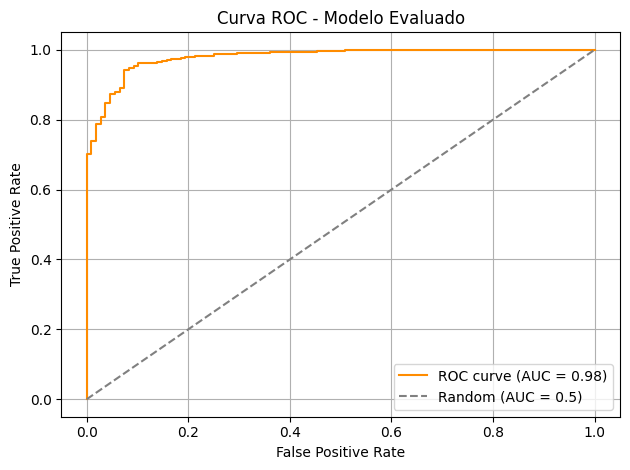

In [ ]:
# ================================
# 1. CONFIGURACIÓN DE RUTAS
# ================================
carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"
modelo_path = '/content/drive/MyDrive/TELEFONICA/modelos_entrenados/modelo_svm_rbf.pkl'
male_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.male.trl.txt"
female_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.female.trl.txt"

# ================================
# 2. CARGAR MODELO + HuBERT
# ================================
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()
model = joblib.load(modelo_path)

def extract_hubert_embedding(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.numel() == 0:
        raise ValueError(f"Audio vacío: {file_path}")
    waveform = waveform.mean(dim=0) if waveform.ndim > 1 else waveform
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    input_tensor = waveform.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = hubert_model(input_tensor)
    hidden_states = outputs.last_hidden_state.squeeze(0)
    embedding = hidden_states.mean(dim=0).cpu().numpy()
    return embedding

# ================================
# 3. CARGAR PROTOCOLO Y GÉNERO
# ================================
label_dict = {}
attack_type_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label
        attack_type_dict[file_id] = parts[3]

def load_gender_files(path):
    with open(path, "r") as f:
        return {line.strip().split()[1] + ".flac" for line in f}

male_files = load_gender_files(male_trl_path)
female_files = load_gender_files(female_trl_path)

# ================================
# 4. SELECCIONAR 1000 AUDIOS
# ================================
all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]
os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

# ================================
# 5. EVALUACIÓN
# ================================
correct, incorrect = 0, 0
y_true_eval, y_pred_eval = [], []
attack_errors, attack_total = [], []
embeddings = []

male_true, male_pred = [], []
female_true, female_pred = [], []

print("🎧 Evaluando modelo con HuBERT embeddings...\n")

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    try:
        emb = extract_hubert_embedding(full_path).reshape(1, -1)
        embeddings.append(emb[0])
    except Exception as e:
        print(f"⚠️ Error en {audio_file}: {e}")
        continue
    true_label = label_dict[audio_file]
    pred = model.predict(emb)[0]
    y_true_eval.append(true_label)
    y_pred_eval.append(pred)
    if audio_file in male_files:
        male_true.append(true_label)
        male_pred.append(pred)
    elif audio_file in female_files:
        female_true.append(true_label)
        female_pred.append(pred)
    if true_label == 1:
        attack = attack_type_dict[audio_file]
        attack_total.append(attack)
        if pred != true_label:
            attack_errors.append(attack)
    if pred == true_label:
        correct += 1
    else:
        incorrect += 1

# ================================
# 6. RESULTADOS GENERALES
# ================================
accuracy = correct / (correct + incorrect) * 100
print("\n=== RESULTADOS GENERALES ===")
print(f"✔️ Correctas:   {correct}")
print(f"❌ Incorrectas: {incorrect}")
print(f"🎯 Accuracy:    {accuracy:.2f}%")
print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
print("Matriz de confusión:")
print(confusion_matrix(y_true_eval, y_pred_eval))

# ================================
# 7. RESULTADOS POR GÉNERO
# ================================
print("\n=== VOCES MASCULINAS ===")
male_acc = sum(np.array(male_true) == np.array(male_pred)) / len(male_true) * 100 if male_true else 0
print(f"🎧 Total: {len(male_true)}  | Accuracy: {male_acc:.2f}%")
print(confusion_matrix(male_true, male_pred))

print("\n=== VOCES FEMENINAS ===")
female_acc = sum(np.array(female_true) == np.array(female_pred)) / len(female_true) * 100 if female_true else 0
print(f"🎧 Total: {len(female_true)}  | Accuracy: {female_acc:.2f}%")
print(confusion_matrix(female_true, female_pred))

# ================================
# 8. ERRORES POR TIPO DE ATAQUE
# ================================
print("\n=== ERRORES POR TIPO DE ATAQUE (SOLO SPOOF) ===")
total_attack_count = Counter(attack_total)
error_attack_count = Counter(attack_errors)
for attack in sorted(total_attack_count):
    total = total_attack_count[attack]
    errors = error_attack_count.get(attack, 0)
    rate = 100 * errors / total
    print(f"🔸 {attack}: {errors}/{total} mal clasificados ({rate:.1f}%)")

# ================================
# 9. CURVA ROC
# ================================
y_proba = model.predict_proba(np.vstack(embeddings))[:, 1]
fpr, tpr, _ = roc_curve(y_true_eval, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Modelo Evaluado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:



# ================================
# CONFIGURACIÓN
# ================================
carpeta_audios = '/content/drive/MyDrive/TELEFONICA/AUDIOS PRUEBA LATAM - SPOOFS'
modelo_path = '/content/drive/MyDrive/TELEFONICA/modelos_entrenados/modelo_svm_rbf.pkl'
csv_salida = '/content/drive/MyDrive/TELEFONICA/resultados_eval_spoof_only.csv'

# ================================
# CARGAR MODELO Y HuBERT
# ================================
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()
modelo = joblib.load(modelo_path)

# ================================
# FUNCIÓN: Extraer embedding
# ================================
def extract_hubert_embedding(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")

    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.numel() == 0:
        raise ValueError(f"Audio vacío: {file_path}")

    waveform = waveform.mean(dim=0) if waveform.ndim > 1 else waveform
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    input_tensor = waveform.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = hubert_model(input_tensor)

    hidden_states = outputs.last_hidden_state.squeeze(0)
    return hidden_states.mean(dim=0).cpu().numpy()

# ================================
# MAPAS Y LISTAS
# ================================
attack_types = ["StarGAN", "CycleGAN", "Diff", "Diffusion", "TTS", "TTS-StarGAN", "TTS-Diff"]

accent_map = {
    "vem": "Venezuela", "vef": "Venezuela",
    "pem": "Peru", "pef": "Peru",
    "com": "Colombia", "cof": "Colombia",
    "clm": "Chile", "clf": "Chile",
    "arm": "Argentina", "arf": "Argentina",
}

# ================================
# FUNCIONES AUXILIARES
# ================================
def extract_attack_type(filename):
    normalized = filename.replace("_", "-").lower()
    for attack in attack_types:
        if attack.lower().replace("_", "-") in normalized:
            return attack
    return "Unknown"

def extract_accent(filename):
    fname_lower = filename.lower()
    for key, country in accent_map.items():
        if f"_{key}_" in fname_lower or fname_lower.startswith(f"{key}_") or f"-{key}-" in fname_lower:
            return country
    return "Unknown"

def extract_gender(filename):
    fname_lower = filename.lower()
    if re.search(r"_(arf|vef|pef|cof|clf)_", fname_lower):
        return "Female"
    elif re.search(r"_(arm|vem|pem|com|clm)_", fname_lower):
        return "Male"
    else:
        return "Unknown"

def print_stats(stats_dict, title="Stats"):
    print(f"\n=== {title} ===")
    print(f"{'Grupo':<20} | {'Total':>5} | {'Tricked':>7} | {'Error Rate %':>11}")
    print("-" * 50)
    for group, stats in sorted(stats_dict.items()):
        total = stats['total']
        tricked = stats['tricked']
        error_rate = (tricked / total) * 100 if total > 0 else 0
        print(f"{group:<20} | {total:5d} | {tricked:7d} | {error_rate:11.2f}")

def export_summary_csv(filename, header, stats_dict):
    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for group, stats in stats_dict.items():
            total = stats['total']
            tricked = stats['tricked']
            error_rate = (tricked / total) * 100 if total > 0 else 0
            writer.writerow([group, total, tricked, error_rate])

def print_unknown(label, unknown_list):
    if unknown_list:
        print(f"\n[!] Archivos con {label} desconocido ({len(unknown_list)}):")
        for fname in unknown_list:
            print(" -", fname)

# ================================
# EVALUACIÓN
# ================================
attack_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
accent_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
gender_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})

misclassified_samples = []
unknown_attacks = []
unknown_accents = []
unknown_genders = []

audio_files = [f for f in os.listdir(carpeta_audios) if f.endswith(".wav")]
print(f"Found {len(audio_files)} spoof audio files. Running predictions...")

for audio_file in tqdm(audio_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    try:
        features = extract_hubert_embedding(full_path).reshape(1, -1)
        pred = modelo.predict(features)[0]

        attack = extract_attack_type(audio_file)
        if attack == "Unknown":
            unknown_attacks.append(audio_file)
            continue

        accent = extract_accent(audio_file)
        if accent == "Unknown":
            unknown_accents.append(audio_file)

        gender = extract_gender(audio_file)
        if gender == "Unknown":
            unknown_genders.append(audio_file)

        attack_stats[attack]['total'] += 1
        accent_stats[accent]['total'] += 1
        gender_stats[gender]['total'] += 1

        if pred == 0:  # 0 = clasificado como bonafide
            attack_stats[attack]['tricked'] += 1
            accent_stats[accent]['tricked'] += 1
            gender_stats[gender]['tricked'] += 1
            misclassified_samples.append([audio_file, attack, accent, gender])

    except Exception as e:
        print(f"Error procesando {audio_file}: {e}")

# ================================
# RESULTADOS
# ================================
print_stats(attack_stats, title="Errores por tipo de ataque")
print_stats(accent_stats, title="Errores por acento/país")
print_stats(gender_stats, title="Errores por género")

# Exportar resúmenes
export_summary_csv("spoof_attack_error_summary.csv", ["AttackType", "Total", "Tricked", "ErrorRate"], attack_stats)
export_summary_csv("spoof_accent_error_summary.csv", ["Accent", "Total", "Tricked", "ErrorRate"], accent_stats)
export_summary_csv("spoof_gender_error_summary.csv", ["Gender", "Total", "Tricked", "ErrorRate"], gender_stats)

# Exportar errores individuales
with open("spoof_misclassified_samples.csv", "w", newline="") as ef:
    writer = csv.writer(ef)
    writer.writerow(["Filename", "AttackType", "Accent", "Gender"])
    writer.writerows(misclassified_samples)

# Mostrar etiquetas desconocidas
print_unknown("tipo de ataque", unknown_attacks)
print_unknown("acento", unknown_accents)
print_unknown("género", unknown_genders)

print("\n✅ Evaluación completada y archivos exportados.")


Found 240 spoof audio files. Running predictions...


100%|██████████| 240/240 [07:31<00:00,  1.88s/it]


=== Errores por tipo de ataque ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
CycleGAN             |    87 |       2 |        2.30
Diff                 |    75 |      23 |       30.67
StarGAN              |    78 |      18 |       23.08

=== Errores por acento/país ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
Argentina            |    48 |       6 |       12.50
Chile                |    48 |      12 |       25.00
Colombia             |    48 |       5 |       10.42
Peru                 |    48 |      12 |       25.00
Venezuela            |    48 |       8 |       16.67

=== Errores por género ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
Female               |   120 |      21 |       17.50
Male                 |   120 |      22 |       18.33

✅ Evaluación completada y archivos exportados.


In [ ]:
# ================================
# CONFIGURACIÓN
# ================================
carpeta_audios = '/content/drive/MyDrive/TELEFONICA/AUDIOS PRUEBA LATAM - BONAFIDES'
modelo_path = '/content/drive/MyDrive/TELEFONICA/modelos_entrenados/modelo_svm_rbf.pkl'
carpeta_salida = '/content/drive/MyDrive/TELEFONICA/evaluacion_latam'
os.makedirs(carpeta_salida, exist_ok=True)

# ================================
# CARGAR MODELO Y HuBERT
# ================================
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()
modelo = joblib.load(modelo_path)

# ================================
# FUNCIÓN: Extraer embedding
# ================================
def extract_hubert_embedding(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")

    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.numel() == 0:
        raise ValueError(f"Audio vacío: {file_path}")

    waveform = waveform.mean(dim=0) if waveform.ndim > 1 else waveform
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    input_tensor = waveform.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = hubert_model(input_tensor)

    hidden_states = outputs.last_hidden_state.squeeze(0)
    return hidden_states.mean(dim=0).cpu().numpy()

# ================================
# MAPEO DE ACENTO Y GÉNERO
# ================================
accent_map = {
    "vem": "Venezuela", "vef": "Venezuela",
    "pem": "Peru", "pef": "Peru",
    "com": "Colombia", "cof": "Colombia",
    "clm": "Chile", "clf": "Chile",
    "arm": "Argentina", "arf": "Argentina",
}

def extract_accent(filename):
    fname_lower = filename.lower()
    for key, country in accent_map.items():
        if f"_{key}_" in fname_lower or fname_lower.startswith(f"{key}_") or f"-{key}-" in fname_lower:
            return country
    return "Unknown"

def extract_gender(filename):
    fname_lower = filename.lower()
    if re.search(r"_(arf|vef|pef|cof|clf)_", fname_lower):
        return "Female"
    elif re.search(r"_(arm|vem|pem|com|clm)_", fname_lower):
        return "Male"
    else:
        return "Unknown"

# ================================
# EVALUACIÓN
# ================================
accent_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
gender_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
misclassified_samples = []
unknown_accents = []
unknown_genders = []

audio_files = [f for f in os.listdir(carpeta_audios) if f.lower().endswith(('.wav', '.flac'))]
print(f"Found {len(audio_files)} bonafides audio files. Running predictions...")

for audio_file in tqdm(audio_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    try:
        features = extract_hubert_embedding(full_path).reshape(1, -1)
        pred = modelo.predict(features)[0]

        accent = extract_accent(audio_file)
        if accent == "Unknown":
            unknown_accents.append(audio_file)

        gender = extract_gender(audio_file)
        if gender == "Unknown":
            unknown_genders.append(audio_file)

        accent_stats[accent]['total'] += 1
        gender_stats[gender]['total'] += 1

        if pred != 0:  # ❗ Error: bonafide clasificado como spoof
            accent_stats[accent]['tricked'] += 1
            gender_stats[gender]['tricked'] += 1
            misclassified_samples.append([audio_file, accent, gender])

    except Exception as e:
        print(f"Error procesando {audio_file}: {e}")

# ================================
# RESULTADOS
# ================================
def print_stats(stats_dict, title):
    print(f"\n=== {title} ===")
    print(f"{'Grupo':<15} | {'Total':>5} | {'Tricked':>7} | {'Error Rate %':>11}")
    print("-" * 45)
    for group, stats in sorted(stats_dict.items(), key=lambda x: (x[1]['tricked'] / x[1]['total']) if x[1]['total'] > 0 else 0, reverse=True):
        total = stats['total']
        tricked = stats['tricked']
        error_rate = (tricked / total) * 100 if total > 0 else 0
        print(f"{group:<15} | {total:5d} | {tricked:7d} | {error_rate:11.2f}")

print_stats(accent_stats, "Errores por acento/país")
print_stats(gender_stats, "Errores por género")

Found 132 bonafides audio files. Running predictions...


100%|██████████| 132/132 [03:26<00:00,  1.56s/it]


=== Errores por acento/país ===
Grupo           | Total | Tricked | Error Rate %
---------------------------------------------
Venezuela       |    20 |      18 |       90.00
Colombia        |    28 |      23 |       82.14
Argentina       |    24 |      17 |       70.83
Peru            |    36 |      24 |       66.67
Chile           |    24 |      11 |       45.83

=== Errores por género ===
Grupo           | Total | Tricked | Error Rate %
---------------------------------------------
Female          |    66 |      50 |       75.76
Male            |    66 |      43 |       65.15


##### 3.  **modelo_svm_optimizado**

🎧 Evaluando modelo con HuBERT embeddings...



100%|██████████| 1000/1000 [15:18<00:00,  1.09it/s]



=== RESULTADOS GENERALES ===
✔️ Correctas:   808
❌ Incorrectas: 192
🎯 Accuracy:    80.80%
              precision    recall  f1-score   support

    bonafide       0.36      0.99      0.53       108
       spoof       1.00      0.79      0.88       892

    accuracy                           0.81      1000
   macro avg       0.68      0.89      0.70      1000
weighted avg       0.93      0.81      0.84      1000

Matriz de confusión:
[[107   1]
 [191 701]]

=== VOCES MASCULINAS ===
🎧 Total: 274  | Accuracy: 80.29%
[[ 31   0]
 [ 54 189]]

=== VOCES FEMENINAS ===
🎧 Total: 726  | Accuracy: 80.99%
[[ 76   1]
 [137 512]]

=== ERRORES POR TIPO DE ATAQUE (SOLO SPOOF) ===
🔸 A07: 0/63 mal clasificados (0.0%)
🔸 A08: 2/79 mal clasificados (2.5%)
🔸 A09: 0/56 mal clasificados (0.0%)
🔸 A10: 0/71 mal clasificados (0.0%)
🔸 A11: 0/73 mal clasificados (0.0%)
🔸 A12: 0/63 mal clasificados (0.0%)
🔸 A13: 0/67 mal clasificados (0.0%)
🔸 A14: 0/66 mal clasificados (0.0%)
🔸 A15: 0/65 mal clasificados (0.0%)
🔸 

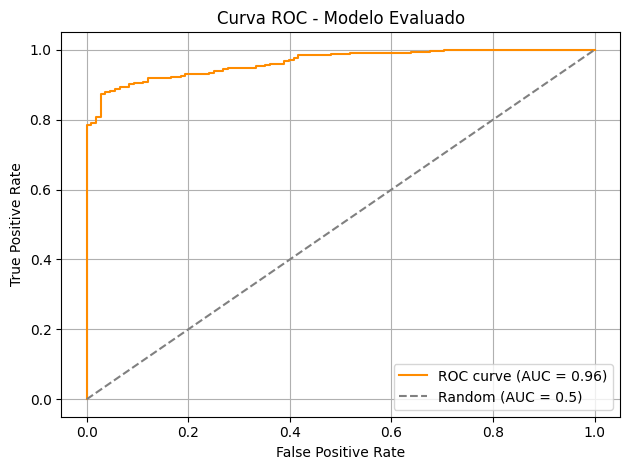

In [ ]:
# ================================
# 1. CONFIGURACIÓN DE RUTAS
# ================================
carpeta_audios = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_eval/flac/"
ruta_protocol = "/content/drive/MyDrive/TELEFONICA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
eval_file_list_path = "/content/drive/MyDrive/TELEFONICA/1000/eval_file_list.json"
modelo_path = '/content/drive/MyDrive/TELEFONICA/modelos_entrenados_optimizados/modelo_svm_optimizado.pkl'
male_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.male.trl.txt"
female_trl_path = "/content/drive/MyDrive/TELEFONICA/NO UTLIZAR NI BORRAR (POR AHORA)/ASVspoof2019_LA_asv_protocols/ASVspoof2019.LA.asv.eval.female.trl.txt"

# ================================
# 2. CARGAR MODELO + HuBERT
# ================================
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()
model = joblib.load(modelo_path)

def extract_hubert_embedding(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.numel() == 0:
        raise ValueError(f"Audio vacío: {file_path}")
    waveform = waveform.mean(dim=0) if waveform.ndim > 1 else waveform
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    input_tensor = waveform.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = hubert_model(input_tensor)
    hidden_states = outputs.last_hidden_state.squeeze(0)
    embedding = hidden_states.mean(dim=0).cpu().numpy()
    return embedding

# ================================
# 3. CARGAR PROTOCOLO Y GÉNERO
# ================================
label_dict = {}
attack_type_dict = {}
with open(ruta_protocol, 'r') as f:
    for line in f:
        parts = line.strip().split()
        file_id = parts[1] + ".flac"
        label = 1 if parts[-1] == 'spoof' else 0
        label_dict[file_id] = label
        attack_type_dict[file_id] = parts[3]

def load_gender_files(path):
    with open(path, "r") as f:
        return {line.strip().split()[1] + ".flac" for line in f}

male_files = load_gender_files(male_trl_path)
female_files = load_gender_files(female_trl_path)

# ================================
# 4. SELECCIONAR 1000 AUDIOS
# ================================
all_files = list(label_dict.keys())
existing_files = [f for f in all_files if os.path.exists(os.path.join(carpeta_audios, f))]
os.makedirs(os.path.dirname(eval_file_list_path), exist_ok=True)

if os.path.exists(eval_file_list_path):
    with open(eval_file_list_path, "r") as f:
        selected_files = json.load(f)
else:
    selected_files = random.sample(existing_files, min(1000, len(existing_files)))
    with open(eval_file_list_path, "w") as f:
        json.dump(selected_files, f)

# ================================
# 5. EVALUACIÓN
# ================================
correct, incorrect = 0, 0
y_true_eval, y_pred_eval = [], []
attack_errors, attack_total = [], []
embeddings = []

male_true, male_pred = [], []
female_true, female_pred = [], []

print("🎧 Evaluando modelo con HuBERT embeddings...\n")

for audio_file in tqdm(selected_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    try:
        emb = extract_hubert_embedding(full_path).reshape(1, -1)
        embeddings.append(emb[0])
    except Exception as e:
        print(f"⚠️ Error en {audio_file}: {e}")
        continue
    true_label = label_dict[audio_file]
    pred = model.predict(emb)[0]
    y_true_eval.append(true_label)
    y_pred_eval.append(pred)
    if audio_file in male_files:
        male_true.append(true_label)
        male_pred.append(pred)
    elif audio_file in female_files:
        female_true.append(true_label)
        female_pred.append(pred)
    if true_label == 1:
        attack = attack_type_dict[audio_file]
        attack_total.append(attack)
        if pred != true_label:
            attack_errors.append(attack)
    if pred == true_label:
        correct += 1
    else:
        incorrect += 1

# ================================
# 6. RESULTADOS GENERALES
# ================================
accuracy = correct / (correct + incorrect) * 100
print("\n=== RESULTADOS GENERALES ===")
print(f"✔️ Correctas:   {correct}")
print(f"❌ Incorrectas: {incorrect}")
print(f"🎯 Accuracy:    {accuracy:.2f}%")
print(classification_report(y_true_eval, y_pred_eval, target_names=["bonafide", "spoof"]))
print("Matriz de confusión:")
print(confusion_matrix(y_true_eval, y_pred_eval))

# ================================
# 7. RESULTADOS POR GÉNERO
# ================================
print("\n=== VOCES MASCULINAS ===")
male_acc = sum(np.array(male_true) == np.array(male_pred)) / len(male_true) * 100 if male_true else 0
print(f"🎧 Total: {len(male_true)}  | Accuracy: {male_acc:.2f}%")
print(confusion_matrix(male_true, male_pred))

print("\n=== VOCES FEMENINAS ===")
female_acc = sum(np.array(female_true) == np.array(female_pred)) / len(female_true) * 100 if female_true else 0
print(f"🎧 Total: {len(female_true)}  | Accuracy: {female_acc:.2f}%")
print(confusion_matrix(female_true, female_pred))

# ================================
# 8. ERRORES POR TIPO DE ATAQUE
# ================================
print("\n=== ERRORES POR TIPO DE ATAQUE (SOLO SPOOF) ===")
total_attack_count = Counter(attack_total)
error_attack_count = Counter(attack_errors)
for attack in sorted(total_attack_count):
    total = total_attack_count[attack]
    errors = error_attack_count.get(attack, 0)
    rate = 100 * errors / total
    print(f"🔸 {attack}: {errors}/{total} mal clasificados ({rate:.1f}%)")

# ================================
# 9. CURVA ROC
# ================================
y_proba = model.predict_proba(np.vstack(embeddings))[:, 1]
fpr, tpr, _ = roc_curve(y_true_eval, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Modelo Evaluado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### PRUEBA CON AUDIO DE LATAM -XGBOOST




#### AUDIOS FALSOS - LATAM

In [ ]:
# ================================
# CONFIGURACIÓN
# ================================
carpeta_audios = '/content/drive/MyDrive/TELEFONICA/AUDIOS PRUEBA LATAM - SPOOFS'
modelo_path = '/content/drive/MyDrive/TELEFONICA/modelos_entrenados_optimizados/modelo_xgboost_optimizado.pkl'

# ================================
# CARGAR MODELO Y HuBERT
# ================================
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()
modelo = joblib.load(modelo_path)

# ================================
# FUNCIÓN: Extraer embedding
# ================================
def extract_hubert_embedding(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.numel() == 0:
        raise ValueError(f"Audio vacío: {file_path}")
    waveform = waveform.mean(dim=0) if waveform.ndim > 1 else waveform
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    input_tensor = waveform.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = hubert_model(input_tensor)
    hidden_states = outputs.last_hidden_state.squeeze(0)
    return hidden_states.mean(dim=0).cpu().numpy()

# ================================
# MAPAS Y LISTAS
# ================================
attack_types = ["StarGAN", "CycleGAN", "Diff", "Diffusion", "TTS", "TTS-StarGAN", "TTS-Diff"]
accent_map = {
    "vem": "Venezuela", "vef": "Venezuela",
    "pem": "Peru", "pef": "Peru",
    "com": "Colombia", "cof": "Colombia",
    "clm": "Chile", "clf": "Chile",
    "arm": "Argentina", "arf": "Argentina",
}

# ================================
# FUNCIONES AUXILIARES
# ================================
def extract_attack_type(filename):
    normalized = filename.replace("_", "-").lower()
    for attack in attack_types:
        if attack.lower().replace("_", "-") in normalized:
            return attack
    return "Unknown"

def extract_accent(filename):
    fname_lower = filename.lower()
    for key, country in accent_map.items():
        if f"_{key}_" in fname_lower or fname_lower.startswith(f"{key}_") or f"-{key}-" in fname_lower:
            return country
    return "Unknown"

def extract_gender(filename):
    fname_lower = filename.lower()
    if re.search(r"_(arf|vef|pef|cof|clf)_", fname_lower):
        return "Female"
    elif re.search(r"_(arm|vem|pem|com|clm)_", fname_lower):
        return "Male"
    else:
        return "Unknown"

def print_stats(stats_dict, title="Stats"):
    print(f"\n=== {title} ===")
    print(f"{'Grupo':<20} | {'Total':>5} | {'Tricked':>7} | {'Error Rate %':>11}")
    print("-" * 50)
    for group, stats in sorted(stats_dict.items()):
        total = stats['total']
        tricked = stats['tricked']
        error_rate = (tricked / total) * 100 if total > 0 else 0
        print(f"{group:<20} | {total:5d} | {tricked:7d} | {error_rate:11.2f}")

def print_unknown(label, unknown_list):
    if unknown_list:
        print(f"\n[!] Archivos con {label} desconocido ({len(unknown_list)}):")
        for fname in unknown_list:
            print(" -", fname)

# ================================
# EVALUACIÓN
# ================================
attack_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
accent_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
gender_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})

misclassified_samples = []
unknown_attacks = []
unknown_accents = []
unknown_genders = []

audio_files = [f for f in os.listdir(carpeta_audios) if f.endswith(".wav")]
print(f"Found {len(audio_files)} spoof audio files. Running predictions...")

for audio_file in tqdm(audio_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    try:
        features = extract_hubert_embedding(full_path).reshape(1, -1)
        pred = modelo.predict(features)[0]

        attack = extract_attack_type(audio_file)
        if attack == "Unknown":
            unknown_attacks.append(audio_file)
            continue

        accent = extract_accent(audio_file)
        if accent == "Unknown":
            unknown_accents.append(audio_file)

        gender = extract_gender(audio_file)
        if gender == "Unknown":
            unknown_genders.append(audio_file)

        attack_stats[attack]['total'] += 1
        accent_stats[accent]['total'] += 1
        gender_stats[gender]['total'] += 1

        if pred == 0:  # 0 = clasificado como bonafide
            attack_stats[attack]['tricked'] += 1
            accent_stats[accent]['tricked'] += 1
            gender_stats[gender]['tricked'] += 1
            misclassified_samples.append([audio_file, attack, accent, gender])

    except Exception as e:
        print(f"Error procesando {audio_file}: {e}")

# ================================
# RESULTADOS
# ================================
print_stats(attack_stats, title="Errores por tipo de ataque")
print_stats(accent_stats, title="Errores por acento/país")
print_stats(gender_stats, title="Errores por género")
print_unknown("tipo de ataque", unknown_attacks)
print_unknown("acento", unknown_accents)
print_unknown("género", unknown_genders)

print("\n✅ Evaluación completada.")


Found 240 spoof audio files. Running predictions...


100%|██████████| 240/240 [07:26<00:00,  1.86s/it]


=== Errores por tipo de ataque ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
CycleGAN             |    87 |       1 |        1.15
Diff                 |    75 |      34 |       45.33
StarGAN              |    78 |      40 |       51.28

=== Errores por acento/país ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
Argentina            |    48 |      20 |       41.67
Chile                |    48 |      15 |       31.25
Colombia             |    48 |      10 |       20.83
Peru                 |    48 |      17 |       35.42
Venezuela            |    48 |      13 |       27.08

=== Errores por género ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
Female               |   120 |      35 |       29.17
Male                 |   120 |      40 |       33.33

✅ Evaluación completada.


In [ ]:
def print_stats(stats_dict, title="Stats"):
    print(f"\n=== {title} ===")
    print(f"{'Grupo':<20} | {'Total':>5} | {'Tricked':>7} | {'Error Rate %':>11}")
    print("-" * 50)

    total_all = 0
    tricked_all = 0

    for group, stats in sorted(stats_dict.items()):
        try:
            total = stats['total']
            tricked = stats['tricked']
        except KeyError:
            print(f"[ERROR] Grupo sin clave esperada: {group}, contenido: {stats}")
            continue

        error_rate = (tricked / total) * 100 if total > 0 else 0
        total_all += total
        tricked_all += tricked
        print(f"{group:<20} | {total:5d} | {tricked:7d} | {error_rate:11.2f}")

    print("-" * 50)
    if total_all > 0:
        total_error_rate = (tricked_all / total_all) * 100
        print(f"{'TOTAL GENERAL':<20} | {total_all:5d} | {tricked_all:7d} | {total_error_rate:11.2f}")
    else:
        print("⚠️ No se encontraron datos válidos para calcular TOTAL GENERAL.")


In [ ]:
print(f"attack_stats: {dict(attack_stats)}")
print_stats(attack_stats, title="Errores por tipo de ataque")

attack_stats: {'CycleGAN': {'total': 87, 'tricked': 1}, 'Diff': {'total': 75, 'tricked': 34}, 'StarGAN': {'total': 78, 'tricked': 40}}

=== Errores por tipo de ataque ===
Grupo                | Total | Tricked | Error Rate %
--------------------------------------------------
CycleGAN             |    87 |       1 |        1.15
Diff                 |    75 |      34 |       45.33
StarGAN              |    78 |      40 |       51.28
--------------------------------------------------
TOTAL GENERAL        |   240 |      75 |       31.25


#### AUDIOS VERDADES -LATAM

In [ ]:
# ================================
# CONFIGURACIÓN
# ================================
carpeta_audios = '/content/drive/MyDrive/TELEFONICA/AUDIOS PRUEBA LATAM - BONAFIDES'
modelo_path = '/content/drive/MyDrive/TELEFONICA/modelos_entrenados_optimizados/modelo_xgboost_optimizado.pkl'
carpeta_salida = '/content/drive/MyDrive/TELEFONICA/evaluacion_latam'
os.makedirs(carpeta_salida, exist_ok=True)

# ================================
# CARGAR MODELO Y HuBERT
# ================================
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()
modelo = joblib.load(modelo_path)

# ================================
# FUNCIÓN: Extraer embedding
# ================================
def extract_hubert_embedding(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")

    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.numel() == 0:
        raise ValueError(f"Audio vacío: {file_path}")

    waveform = waveform.mean(dim=0) if waveform.ndim > 1 else waveform
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    input_tensor = waveform.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = hubert_model(input_tensor)

    hidden_states = outputs.last_hidden_state.squeeze(0)
    return hidden_states.mean(dim=0).cpu().numpy()

# ================================
# MAPEO DE ACENTO Y GÉNERO
# ================================
accent_map = {
    "vem": "Venezuela", "vef": "Venezuela",
    "pem": "Peru", "pef": "Peru",
    "com": "Colombia", "cof": "Colombia",
    "clm": "Chile", "clf": "Chile",
    "arm": "Argentina", "arf": "Argentina",
}

def extract_accent(filename):
    fname_lower = filename.lower()
    for key, country in accent_map.items():
        if f"_{key}_" in fname_lower or fname_lower.startswith(f"{key}_") or f"-{key}-" in fname_lower:
            return country
    return "Unknown"

def extract_gender(filename):
    fname_lower = filename.lower()
    if re.search(r"_(arf|vef|pef|cof|clf)_", fname_lower):
        return "Female"
    elif re.search(r"_(arm|vem|pem|com|clm)_", fname_lower):
        return "Male"
    else:
        return "Unknown"

# ================================
# EVALUACIÓN
# ================================
accent_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
gender_stats = defaultdict(lambda: {'total': 0, 'tricked': 0})
misclassified_samples = []
unknown_accents = []
unknown_genders = []

audio_files = [f for f in os.listdir(carpeta_audios) if f.lower().endswith(('.wav', '.flac'))]
print(f"Found {len(audio_files)} bonafides audio files. Running predictions...")

for audio_file in tqdm(audio_files):
    full_path = os.path.join(carpeta_audios, audio_file)
    try:
        features = extract_hubert_embedding(full_path).reshape(1, -1)
        pred = modelo.predict(features)[0]

        accent = extract_accent(audio_file)
        if accent == "Unknown":
            unknown_accents.append(audio_file)

        gender = extract_gender(audio_file)
        if gender == "Unknown":
            unknown_genders.append(audio_file)

        accent_stats[accent]['total'] += 1
        gender_stats[gender]['total'] += 1

        if pred != 0:  # ❗ Error: bonafide clasificado como spoof
            accent_stats[accent]['tricked'] += 1
            gender_stats[gender]['tricked'] += 1
            misclassified_samples.append([audio_file, accent, gender])

    except Exception as e:
        print(f"Error procesando {audio_file}: {e}")

# ================================
# RESULTADOS
# ================================
def print_stats(stats_dict, title):
    print(f"\n=== {title} ===")
    print(f"{'Grupo':<15} | {'Total':>5} | {'Tricked':>7} | {'Error Rate %':>11}")
    print("-" * 45)
    for group, stats in sorted(stats_dict.items(), key=lambda x: (x[1]['tricked'] / x[1]['total']) if x[1]['total'] > 0 else 0, reverse=True):
        total = stats['total']
        tricked = stats['tricked']
        error_rate = (tricked / total) * 100 if total > 0 else 0
        print(f"{group:<15} | {total:5d} | {tricked:7d} | {error_rate:11.2f}")

print_stats(accent_stats, "Errores por acento/país")
print_stats(gender_stats, "Errores por género")

Found 132 bonafides audio files. Running predictions...


100%|██████████| 132/132 [04:23<00:00,  2.00s/it]


=== Errores por acento/país ===
Grupo           | Total | Tricked | Error Rate %
---------------------------------------------
Colombia        |    28 |      22 |       78.57
Venezuela       |    20 |      15 |       75.00
Peru            |    36 |      19 |       52.78
Chile           |    24 |       9 |       37.50
Argentina       |    24 |       4 |       16.67

=== Errores por género ===
Grupo           | Total | Tricked | Error Rate %
---------------------------------------------
Female          |    66 |      37 |       56.06
Male            |    66 |      32 |       48.48


#PARTE OPCIONAL : Comprobacion con GRADIO

In [ ]:
#!pip install pydub
#!apt install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.0 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import torch
import torchaudio
import joblib
import numpy as np
from transformers import HubertModel

# === Cargar modelo y HuBERT
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device).eval()
modelo = joblib.load("/content/drive/MyDrive/TELEFONICA/modelos_entrenados/modelo_svm.pkl")

# === Extraer embedding desde audio
def extract_hubert_embedding(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.ndim > 1:
        waveform = waveform.mean(dim=0)
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    input_tensor = waveform.unsqueeze(0).to(device)
    with torch.no_grad():
        output = hubert(input_tensor)
    return output.last_hidden_state.squeeze(0).mean(dim=0).cpu().numpy()

# === Función principal Gradio
def detectar_spoof(file):
    try:
        emb = extract_hubert_embedding(file.name).reshape(1, -1)
        pred = modelo.predict(emb)[0]
        return "🟢 Bonafide" if pred == 0 else "🔴 Spoof"
    except Exception as e:
        return f"❌ Error: {str(e)}"

# === Interfaz Gradio simple
demo = gr.Interface(
    fn=detectar_spoof,
    inputs=gr.File(file_types=[".wav", ".flac"], label="🔊 Sube un audio (.wav o .flac)"),
    outputs=gr.Label(label="Predicción"),
    title="🧠 Detector de Spoof (HuBERT + SVM)",
    description="Sube un archivo de audio para saber si es bonafide o spoof. Sin necesidad de país ni género.",
)

demo.launch(share=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://96f17f718fae9072ee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
